In [1]:
# Change the path if necessary
datasets_path = 'datasets'

import sys
import os

# Deploy AML code in colab
if 'google.colab' in sys.modules:
    if not os.path.exists('/content/applied-ml/'):
        !wget -q https://raw.githubusercontent.com/tsunrise/colab-github/main/colab_github.py
        import colab_github
        colab_github.github_auth(persistent_key=False)

        %cd /content/
        !git clone git@github.com:oz-e/applied-ml.git
        if not os.path.exists('/content/applied-ml/'):
            raise Exception('Please follow the instructions to add the SSH key to your account in order to clone private repo')

    %cd /content/applied-ml/

    # Install any other requirements (to be converted to requirements.txt)
    !pip install openai-clip

In [2]:
import os

if not os.path.exists('CuPL'):
    !git clone https://github.com/sarahpratt/CuPL.git

In [3]:
import numpy as np
import torch
import clip
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from CuPL.imagenet_prompts.standard_image_prompts import imagenet_templates

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
model, preprocess = clip.load('ViT-B/16', device=device, jit=False)

In [6]:
import aml.datasets

dataset_test = aml.datasets.DTD(datasets_path, split='test')

In [7]:
cls_names_sorted = [dataset_test.lab2cname[label_id] for label_id in sorted(dataset_test.lab2cname.keys())]

In [8]:
# Create class name features
with torch.no_grad():
    cls_name_label_ids = np.arange(len(cls_names_sorted))
    cls_name_features_cuda = model.encode_text(clip.tokenize(cls_names_sorted).to(device))
    cls_name_features_cuda /= cls_name_features_cuda.norm(dim=-1, keepdim=True)
    cls_name_features = cls_name_features_cuda.cpu().numpy()

    # Fill diagonal for better visibility
    cls_name_masked_similarity = (cls_name_features_cuda @ cls_name_features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy()

In [9]:
def calc_features(encoder, items_dict):
    with torch.no_grad():
        label_ids = []
        features_cuda = []
        cls_features_cuda = []
        for label_id in tqdm(range(len(cls_names_sorted))):
            items = items_dict.pop(label_id)
            label_ids.append([label_id] * len(items))
            class_embeddings = encoder(items)
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            features_cuda.append(class_embeddings)
            cls_features_cuda.append(class_embedding)
        label_ids = np.hstack(label_ids)
        features = torch.vstack(features_cuda).cpu().numpy()
        cls_features_cuda = torch.vstack(cls_features_cuda)

        # Fill diagonal for better visibility
        masked_similarity = (cls_features_cuda @ cls_features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy()

    return label_ids, features, features_cuda, cls_features_cuda, masked_similarity

In [10]:
def encode_text(texts):
    with torch.no_grad():
        return model.encode_text(clip.tokenize(texts).to(device))

In [11]:
# Create template text features
template_label_texts_list = {label_id: [template.format(cls_name) for template in imagenet_templates] for label_id, cls_name in enumerate(cls_names_sorted)}
template_label_ids, template_text_features, template_text_features_cuda, template_cls_features_cuda, template_masked_similarity = calc_features(encode_text, template_label_texts_list)

100%|██████████| 47/47 [00:00<00:00, 49.32it/s]


In [12]:
PATH_TO_PROMPTS = './CuPL/all_prompts/full_prompts/texture_prompts_full.json'

with open(PATH_TO_PROMPTS) as f:
    gpt3_prompts_file = json.load(f)

In [13]:
# Mapping between CuPL and cls_name
special_class_mapping = {
}

In [14]:
# Lookup CuLP prompts from cls_name
original_gpt3_prompts = {}

for gpt3_cls_name, texts in gpt3_prompts_file.items():
    cls_name = special_class_mapping.get(gpt3_cls_name, gpt3_cls_name).replace(' ', '_')
    if cls_name not in dataset_test.classnames:
        continue
    original_gpt3_prompts[cls_name] = texts

In [15]:
# Create original gpt3 text features
original_gpt3_label_texts_list = {label_id: original_gpt3_prompts[cls_name] for label_id, cls_name in enumerate(cls_names_sorted)}
original_gpt3_label_ids, original_gpt3_text_features, original_gpt3_text_features_cuda, original_gpt3_cls_features_cuda, original_gpt3_masked_similarity = calc_features(encode_text, original_gpt3_label_texts_list)

100%|██████████| 47/47 [00:00<00:00, 59.76it/s]


In [16]:
# Hyperparameters for filtering outliers in gpt3 texts

# Minimum mean similarity
similarity_mean_threshold = 0.7

# Minimum similarity to be counted as dissimilar
similarity_count_threshold = 0.65
# Filter if it is dissimilar from more than (1-ratio) of the other texts
similarity_count_ratio = 0.5

In [17]:
# Filter out outliers in gpt3 text features
with torch.no_grad():
    # Remove duplicates
    unique_gpt3_prompts = {label_id: list(dict.fromkeys(original_gpt3_prompts[cls_name])) for label_id, cls_name in enumerate(cls_names_sorted)}
    _, _, unique_gpt3_text_features_cuda, _, _ = calc_features(encode_text, unique_gpt3_prompts.copy())

    unique_gpt3_text_similarity = [(features_cuda @ features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy() for features_cuda in unique_gpt3_text_features_cuda]
    unique_gpt3_text_similarity_mean = [np.nanmean(similarity, axis=0) for similarity in unique_gpt3_text_similarity]
    unique_gpt3_text_similarity_count_mean = [(similarity >= similarity_count_threshold).mean(axis=0) for similarity in unique_gpt3_text_similarity]
    filtered_gpt3_prompts = {label_id: [text for text, similarity_mean, similarity_count in zip(texts, similarity_means, similarity_counts) if similarity_mean >= similarity_mean_threshold and similarity_count >= similarity_count_ratio] for (label_id, texts), similarity_means, similarity_counts in zip(unique_gpt3_prompts.items(), unique_gpt3_text_similarity_mean, unique_gpt3_text_similarity_count_mean)}
    # Print filtered prompts
    outlier_gpt3_prompts = {label_id: [text for text, similarity_mean, similarity_count in zip(texts, similarity_means, similarity_counts) if not (similarity_mean >= similarity_mean_threshold and similarity_count >= similarity_count_ratio)] for (label_id, texts), similarity_means, similarity_counts in zip(unique_gpt3_prompts.items(), unique_gpt3_text_similarity_mean, unique_gpt3_text_similarity_count_mean)}
    top_filtered_label_id = None
    top_filtered_count = 0
    for label_id, texts in outlier_gpt3_prompts.items():
        filtered_count = len(texts)
        if filtered_count != 0:
            print(f'Filtered {filtered_count} outliers for ({label_id}){cls_names_sorted[label_id]}')
            print(texts)
            print()
            if filtered_count > top_filtered_count:
                top_filtered_count = filtered_count
                top_filtered_label_id = label_id

100%|██████████| 47/47 [00:00<00:00, 67.22it/s]

Filtered 1 outliers for (6)cobwebbed
['Dusty and old.']

Filtered 1 outliers for (10)dotted
['AAPL\'s earnings release yesterday was "dotted" with strong quarterly results.']

Filtered 1 outliers for (18)honeycombed
['a.']



Class: (6)cobwebbed
(39)Dusty and old.


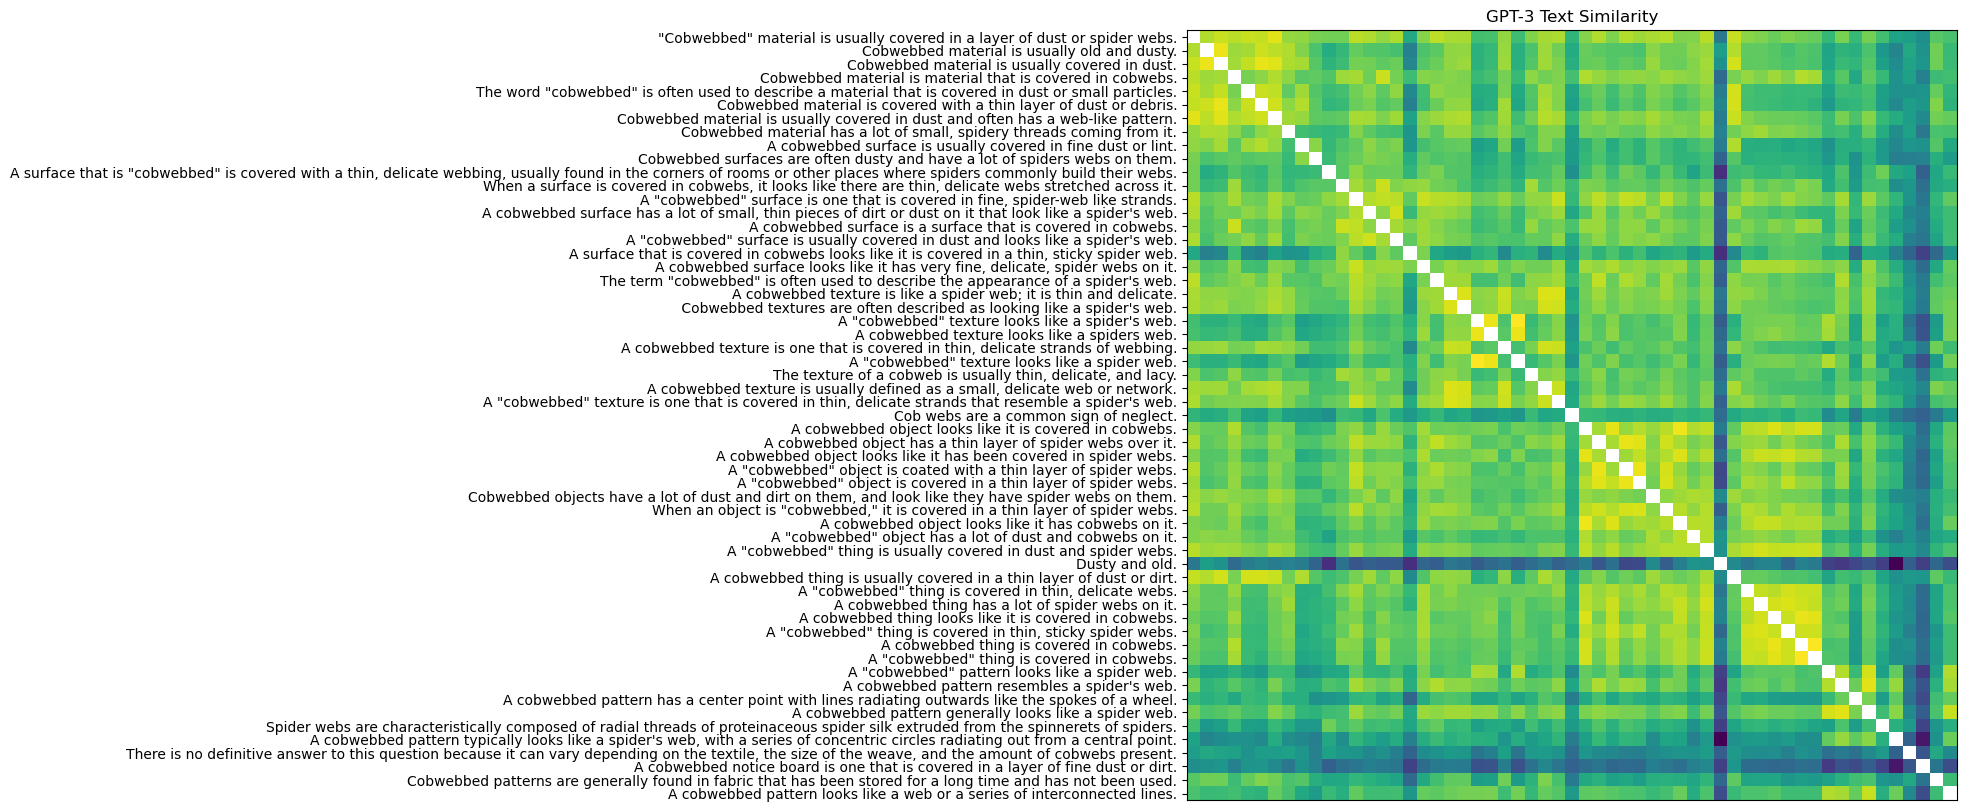

In [18]:
# Visualize dis-similarities of outliers
print(f'Class: ({top_filtered_label_id}){cls_names_sorted[top_filtered_label_id]}')
ylabels = unique_gpt3_prompts[top_filtered_label_id]
for text in outlier_gpt3_prompts[top_filtered_label_id]:
    print(f'({ylabels.index(text)}){text}')
plt.figure(figsize=(12, 10))
plt.imshow(unique_gpt3_text_similarity[top_filtered_label_id])
plt.xticks([])
plt.yticks(np.arange(0, len(ylabels)), ylabels)
plt.title('GPT-3 Text Similarity')
plt.show()

In [19]:
# Create filtered gpt3 text features
filtered_gpt3_label_texts_list = {label_id: filtered_gpt3_prompts[label_id] for label_id in range(len(cls_names_sorted))}
filtered_gpt3_label_ids, filtered_gpt3_text_features, filtered_gpt3_text_features_cuda, filtered_gpt3_cls_features_cuda, filtered_gpt3_masked_similarity = calc_features(encode_text, filtered_gpt3_label_texts_list)

100%|██████████| 47/47 [00:00<00:00, 66.04it/s]


In [20]:
def encode_images(imgs):
    with torch.no_grad():
        return model.encode_image(torch.stack([preprocess(img) for img in imgs]).to(device))

In [21]:
# Create image features
imgs_grouped = defaultdict(list)
for img, label_id in dataset_test:
    imgs_grouped[label_id].append(img)
img_label_ids, _, img_features_cuda, _, img_masked_similarity = calc_features(encode_images, imgs_grouped)

100%|██████████| 47/47 [00:14<00:00,  3.18it/s]


In [22]:
import sklearn.metrics

def calc_clip_pred(label_ids, img_features_cuda, text_features_cuda):
    with torch.no_grad():
        if type(text_features_cuda) == list:  # list of tensors
            logits = torch.vstack([(img_features_cuda @ embeddings.T).mean(dim=-1) for embeddings in text_features_cuda]).T
        else:
            logits = img_features_cuda @ text_features_cuda.T
        pred = logits.argmax(dim=-1).cpu().numpy()

        return (pred == label_ids).mean(), sklearn.metrics.confusion_matrix(label_ids, pred, labels=np.arange(len(cls_names_sorted)), normalize='true')

In [23]:
# Combine template text with gpt3 text features
combined_original_gpt3_text_features_cuda = [torch.vstack((text_features1, text_features2)) for text_features1, text_features2 in zip(template_text_features_cuda, original_gpt3_text_features_cuda)]
combined_filtered_gpt3_text_features_cuda = [torch.vstack((text_features1, text_features2)) for text_features1, text_features2 in zip(template_text_features_cuda, filtered_gpt3_text_features_cuda)]
combined_original_gpt3_cls_features_cuda = []
combined_filtered_gpt3_cls_features_cuda = []
for class_embeddings in combined_original_gpt3_text_features_cuda:
    class_embedding = class_embeddings.mean(dim=0)
    class_embedding /= class_embedding.norm()
    combined_original_gpt3_cls_features_cuda.append(class_embedding)
for class_embeddings in combined_filtered_gpt3_text_features_cuda:
    class_embedding = class_embeddings.mean(dim=0)
    class_embedding /= class_embedding.norm()
    combined_filtered_gpt3_cls_features_cuda.append(class_embedding)
combined_original_gpt3_cls_features_cuda = torch.vstack(combined_original_gpt3_cls_features_cuda)
combined_filtered_gpt3_cls_features_cuda = torch.vstack(combined_filtered_gpt3_cls_features_cuda)

In [24]:
# Zero-shot classification of CLIP
img_features_stacked_cuda = torch.vstack(img_features_cuda)

cls_name_acc, cls_name_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, cls_name_features_cuda)
template_cls_acc, template_cls_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, template_cls_features_cuda)
template_text_acc, template_text_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, template_text_features_cuda)
original_gpt3_cls_acc, original_gpt3_cls_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, original_gpt3_cls_features_cuda)
original_gpt3_text_acc, original_gpt3_text_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, original_gpt3_text_features_cuda)
filtered_gpt3_cls_acc, filtered_gpt3_cls_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, filtered_gpt3_cls_features_cuda)
filtered_gpt3_text_acc, filtered_gpt3_text_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, filtered_gpt3_text_features_cuda)
combined_original_gpt3_cls_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_original_gpt3_cls_features_cuda)
combined_original_gpt3_text_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_original_gpt3_text_features_cuda)
combined_filtered_gpt3_cls_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_filtered_gpt3_cls_features_cuda)
combined_filtered_gpt3_text_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_filtered_gpt3_text_features_cuda)

In [25]:
print(f'Accuracy of CLIP with class names: {cls_name_acc*100:.2f}%')
print(f'Accuracy of CLIP with text template (centroid): {template_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with text template (individual avg): {template_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with original GPT-3 text (centroid): {original_gpt3_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with original GPT-3 text (individual avg): {original_gpt3_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with filtered GPT-3 text (centroid): {filtered_gpt3_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with filtered GPT-3 text (individual avg): {filtered_gpt3_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined original GPT-3 text (centroid): {combined_original_gpt3_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined original GPT-3 text (individual avg): {combined_original_gpt3_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined filtered GPT-3 text (centroid): {combined_filtered_gpt3_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined filtered GPT-3 text (individual avg): {combined_filtered_gpt3_text_acc*100:.2f}%')

Accuracy of CLIP with class names: 45.80%
Accuracy of CLIP with text template (centroid): 45.27%
Accuracy of CLIP with text template (individual avg): 45.69%
Accuracy of CLIP with original GPT-3 text (centroid): 53.96%
Accuracy of CLIP with original GPT-3 text (individual avg): 52.54%
Accuracy of CLIP with filtered GPT-3 text (centroid): 53.90%
Accuracy of CLIP with filtered GPT-3 text (individual avg): 52.60%
Accuracy of CLIP with combined original GPT-3 text (centroid): 48.23%
Accuracy of CLIP with combined original GPT-3 text (individual avg): 49.23%
Accuracy of CLIP with combined filtered GPT-3 text (centroid): 48.29%
Accuracy of CLIP with combined filtered GPT-3 text (individual avg): 49.29%


In [26]:
# Zero-shot classification of CLIP using one text on all images
template_text_individual_features_cuda = list(torch.stack(template_text_features_cuda).permute(1, 0, 2))
template_text_individual_acc = np.array([calc_clip_pred(img_label_ids, img_features_stacked_cuda, text_features_cuda)[0] for text_features_cuda in template_text_individual_features_cuda])
original_gpt3_text_individual_features_cuda = list(torch.stack(original_gpt3_text_features_cuda).permute(1, 0, 2))
original_gpt3_text_individual_acc = np.array([calc_clip_pred(img_label_ids, img_features_stacked_cuda, text_features_cuda)[0] for text_features_cuda in original_gpt3_text_individual_features_cuda])

In [27]:
print(f'Accuracy of CLIP with text template (one text on all images): mean={template_text_individual_acc.mean()*100:.2f}%, std={template_text_individual_acc.std()}')
print(f'Accuracy of CLIP with original GPT-3 text (one text on all images): mean={original_gpt3_text_individual_acc.mean()*100:.2f}%, std={original_gpt3_text_individual_acc.std()}')

Accuracy of CLIP with text template (one text on all images): mean=42.24%, std=0.02394437281016734
Accuracy of CLIP with original GPT-3 text (one text on all images): mean=40.83%, std=0.021426781742907828


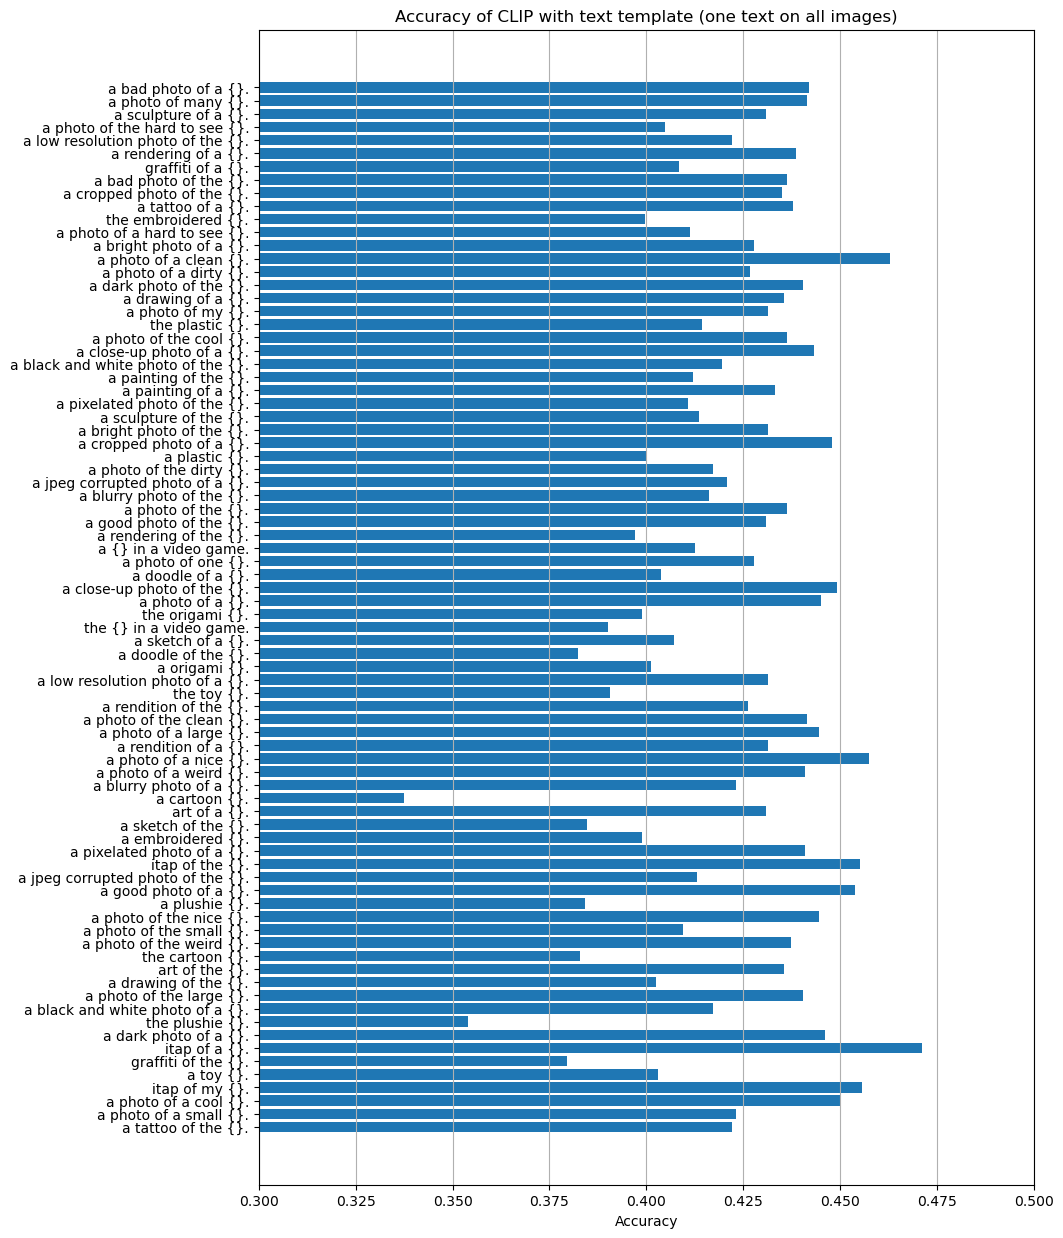

In [28]:
plt.figure(figsize=(10, 15))
plt.barh(np.arange(len(template_text_individual_acc)), template_text_individual_acc, align='center')
plt.yticks(np.arange(len(template_text_individual_acc)), imagenet_templates)
plt.xlabel('Accuracy')
plt.title('Accuracy of CLIP with text template (one text on all images)')
scale = 0.05
plt.xlim(int(template_text_individual_acc.min()/scale)*scale, (int(template_text_individual_acc.max()/scale)+1)*scale)
plt.grid(axis='x')
plt.gca().invert_yaxis()
plt.show()

In [29]:
def calc_features_similarity(features1_cuda, features2_cuda):
    with torch.no_grad():
        similarity_cuda = []
        for embeddings1 in features1_cuda:
            if type(features2_cuda) == list:  # list of tensors
                similarity_cuda.append(torch.Tensor([(embeddings1 @ embeddings2.T).mean() for embeddings2 in features2_cuda]))
            else:
                similarity_cuda.append((embeddings1 @ features2_cuda.T).mean(dim=0))

        return torch.vstack(similarity_cuda).cpu().numpy()

In [30]:
# Calculate similarity between image features and text features
img_cls_name_similarity = calc_features_similarity(img_features_cuda, cls_name_features_cuda)
img_template_cls_similarity = calc_features_similarity(img_features_cuda, template_cls_features_cuda)
img_template_text_similarity = calc_features_similarity(img_features_cuda, template_text_features_cuda)
img_original_gpt3_cls_similarity = calc_features_similarity(img_features_cuda, original_gpt3_cls_features_cuda)
img_original_gpt3_text_similarity = calc_features_similarity(img_features_cuda, original_gpt3_text_features_cuda)
img_filtered_gpt3_cls_similarity = calc_features_similarity(img_features_cuda, filtered_gpt3_cls_features_cuda)
img_filtered_gpt3_text_similarity = calc_features_similarity(img_features_cuda, filtered_gpt3_text_features_cuda)

In [31]:
def print_top_pairs(similarity, text, *, top=10, xlabel='', ylabel='', coordinates=None):
    # Get the indices of top values
    top_indices = np.unravel_index(np.argsort(-similarity, axis=None)[:top], similarity.shape)

    # Extract the class names and labels for top values
    for idx, (label1, label2) in enumerate(zip(*top_indices)):
        if coordinates is None:
            print(f'Rank {idx+1}: ({label1}){ylabel}{cls_names_sorted[label1]} - ({label2}){xlabel}{cls_names_sorted[label2]}, {text}: {similarity[label1, label2]}')
        else:
            print(f'Rank {idx+1}: ({label1}){ylabel}(coor={coordinates[label1][0]:.0f},{coordinates[label1][1]:.0f}){cls_names_sorted[label1]} - ({label2}){xlabel}(coor={coordinates[label1][0]:.0f},{coordinates[label1][1]:.0f}){cls_names_sorted[label2]}, {text}: {similarity[label1, label2]}')

In [32]:
def plot_similarity(similarity, title, xlabel=None, ylabel=None):
    plt.figure(figsize=(12, 10))
    plt.imshow(similarity)
    plt.xticks(np.arange(0, similarity.shape[0], 5))
    plt.yticks(np.arange(0, similarity.shape[1], 5))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar()
    plt.title(title)
    plt.show()

In [33]:
def plot_cm(cm, title):
    plt.figure(figsize=(12, 10))
    plt.imshow(cm)
    plt.xticks(np.arange(0, cm.shape[0], 5))
    plt.yticks(np.arange(0, cm.shape[1], 5))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

In [34]:
def visualize_auto_similarity(masked_similarity, title):
    title_similarity = title + ' Similarity'
    print(f'{title_similarity.capitalize()} mean: {np.nanmean(masked_similarity)}')
    print(f'{title_similarity.capitalize()} std: {np.nanstd(masked_similarity)}')
    print_top_pairs(np.triu(masked_similarity, k=1), 'similarity')
    plot_similarity(masked_similarity, title_similarity)

In [35]:
def visualize_cross_similarity(similarity, cm, title, xlabel='Text', ylabel='Image'):
    title_similarity = title + ' Similarity'
    print(f'{title_similarity.capitalize()} mean: {np.mean(similarity)}')
    print(f'{title_similarity.capitalize()} std: {np.std(similarity)}')
    diagonal_similarity = similarity.diagonal()
    print(f'{title_similarity.capitalize()} diagonal mean: {np.mean(diagonal_similarity)}')
    print(f'{title_similarity.capitalize()} diagonal std: {np.std(diagonal_similarity)}')
    masked_similarity = similarity.copy()
    np.fill_diagonal(masked_similarity, np.nan)
    print(f'{title_similarity.capitalize()} non-diagonal mean: {np.nanmean(masked_similarity)}')
    print(f'{title_similarity.capitalize()} non-diagonal std: {np.nanstd(masked_similarity)}')
    print(f'{title_similarity.capitalize()} diagonal mean to non-diagonal mean ratio: {np.mean(diagonal_similarity)/np.nanmean(masked_similarity)}')
    print_top_pairs(masked_similarity, 'similarity', top=20, xlabel=f'({xlabel})', ylabel=f'({ylabel})')
    plot_similarity(similarity, title_similarity, xlabel=xlabel, ylabel=ylabel)
    masked_cm = cm.copy()
    np.fill_diagonal(masked_cm, np.nan)
    print_top_pairs(masked_cm, 'error rate', top=20, xlabel=f'({xlabel})', ylabel=f'({ylabel})')
    plot_cm(cm, title + ' Confusion Matrix')

Class name similarity mean: 0.7919921875
Class name similarity std: 0.04669189453125
Rank 1: (10)dotted - (30)polka-dotted, similarity: 0.91162109375
Rank 2: (20)knitted - (44)woven, similarity: 0.90771484375
Rank 3: (19)interlaced - (35)spiralled, similarity: 0.90185546875
Rank 4: (1)blotchy - (12)flecked, similarity: 0.900390625
Rank 5: (19)interlaced - (38)stratified, similarity: 0.89697265625
Rank 6: (35)spiralled - (41)swirly, similarity: 0.89697265625
Rank 7: (35)spiralled - (38)stratified, similarity: 0.89306640625
Rank 8: (31)porous - (32)potholed, similarity: 0.89208984375
Rank 9: (25)meshed - (44)woven, similarity: 0.89013671875
Rank 10: (7)cracked - (12)flecked, similarity: 0.8876953125


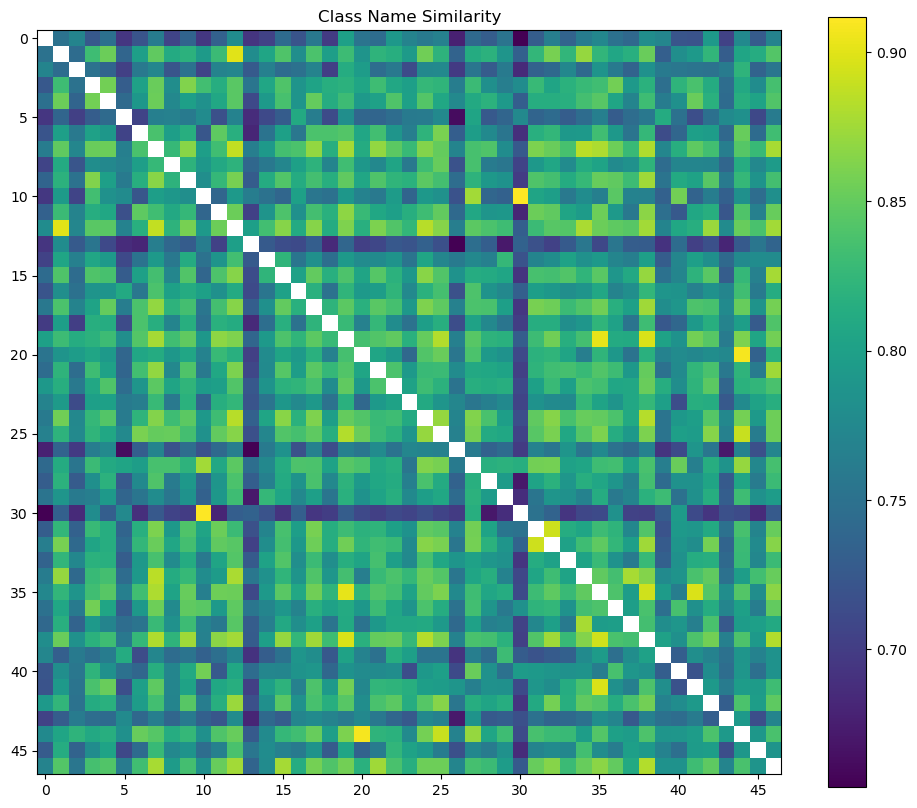

Text template similarity mean: 0.82958984375
Text template similarity std: 0.042633056640625
Rank 1: (1)blotchy - (12)flecked, similarity: 0.943359375
Rank 2: (34)smeared - (37)stained, similarity: 0.935546875
Rank 3: (10)dotted - (30)polka-dotted, similarity: 0.93408203125
Rank 4: (12)flecked - (34)smeared, similarity: 0.93359375
Rank 5: (25)meshed - (44)woven, similarity: 0.93115234375
Rank 6: (12)flecked - (15)gauzy, similarity: 0.92919921875
Rank 7: (1)blotchy - (34)smeared, similarity: 0.92822265625
Rank 8: (35)spiralled - (41)swirly, similarity: 0.92724609375
Rank 9: (10)dotted - (27)perforated, similarity: 0.9228515625
Rank 10: (12)flecked - (32)potholed, similarity: 0.9228515625


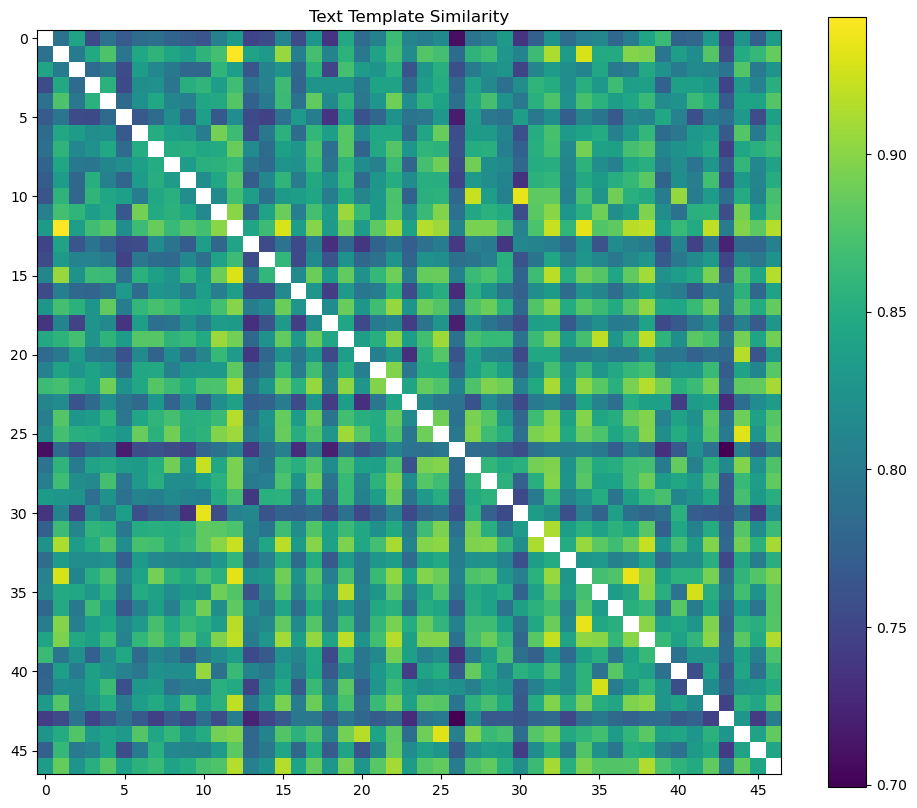

Original gpt-3 text similarity mean: 0.8427734375
Original gpt-3 text similarity std: 0.045562744140625
Rank 1: (35)spiralled - (41)swirly, similarity: 0.95361328125
Rank 2: (1)blotchy - (12)flecked, similarity: 0.9443359375
Rank 3: (28)pitted - (32)potholed, similarity: 0.9443359375
Rank 4: (10)dotted - (30)polka-dotted, similarity: 0.94287109375
Rank 5: (31)porous - (32)potholed, similarity: 0.939453125
Rank 6: (25)meshed - (44)woven, similarity: 0.939453125
Rank 7: (20)knitted - (44)woven, similarity: 0.93896484375
Rank 8: (17)grooved - (22)lined, similarity: 0.93896484375
Rank 9: (19)interlaced - (22)lined, similarity: 0.93798828125
Rank 10: (10)dotted - (27)perforated, similarity: 0.931640625


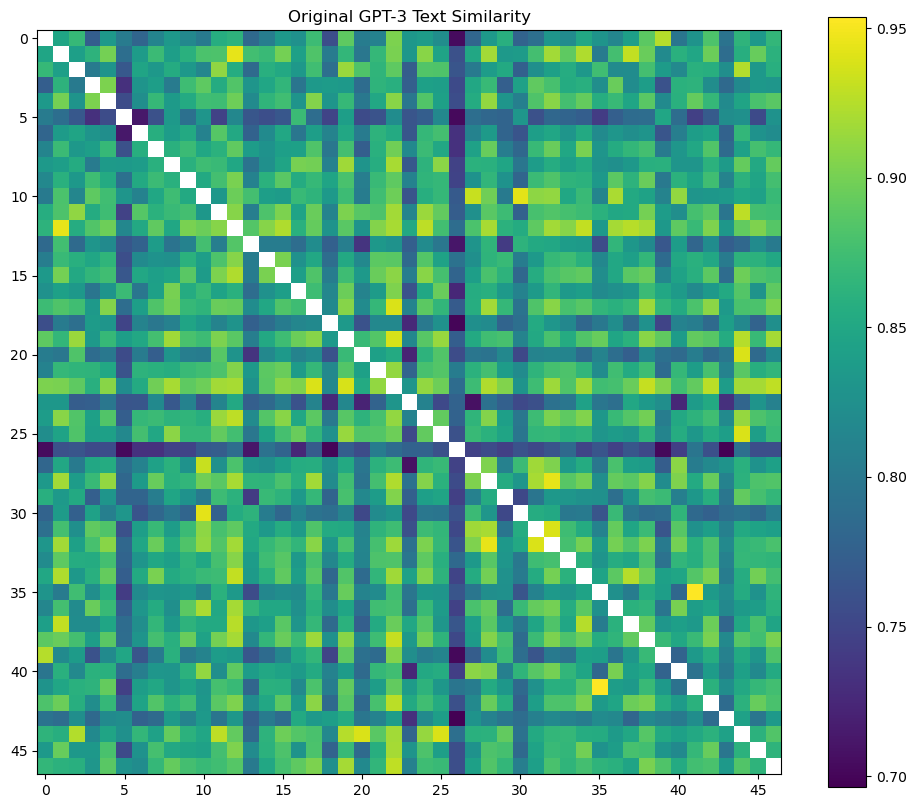

Filtered gpt-3 text similarity mean: 0.84326171875
Filtered gpt-3 text similarity std: 0.045562744140625
Rank 1: (35)spiralled - (41)swirly, similarity: 0.95458984375
Rank 2: (28)pitted - (32)potholed, similarity: 0.94482421875
Rank 3: (1)blotchy - (12)flecked, similarity: 0.9443359375
Rank 4: (10)dotted - (30)polka-dotted, similarity: 0.94384765625
Rank 5: (20)knitted - (44)woven, similarity: 0.939453125
Rank 6: (31)porous - (32)potholed, similarity: 0.939453125
Rank 7: (25)meshed - (44)woven, similarity: 0.939453125
Rank 8: (17)grooved - (22)lined, similarity: 0.9384765625
Rank 9: (19)interlaced - (22)lined, similarity: 0.9375
Rank 10: (10)dotted - (27)perforated, similarity: 0.93359375


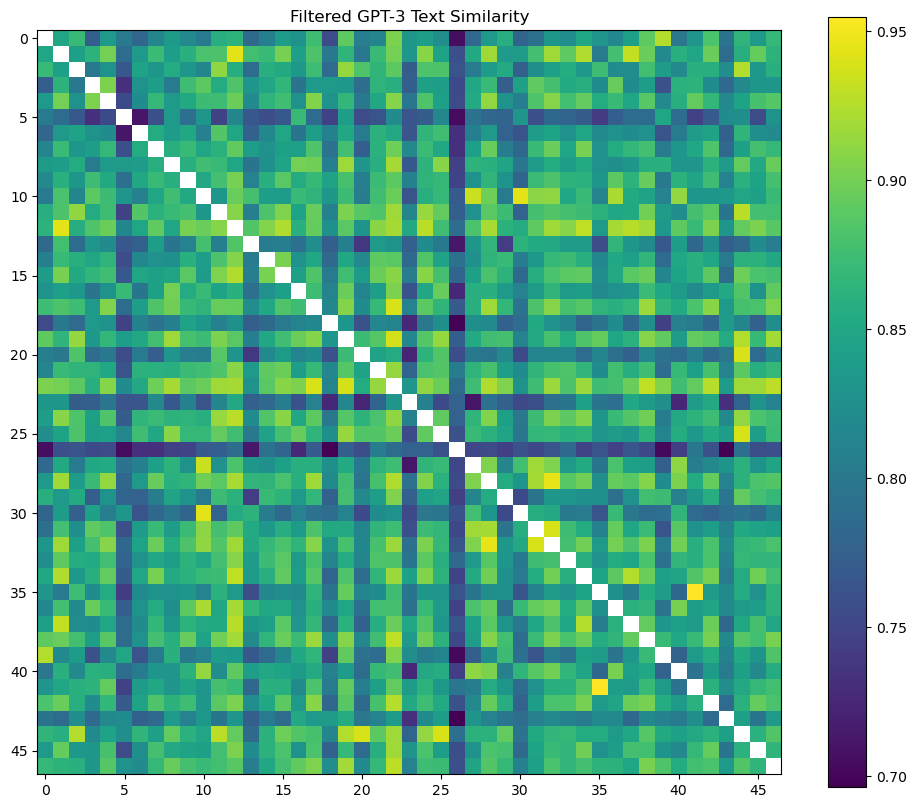

In [36]:
# Auto-similarity of text features
visualize_auto_similarity(cls_name_masked_similarity, 'Class Name')
visualize_auto_similarity(template_masked_similarity, 'Text Template')
visualize_auto_similarity(original_gpt3_masked_similarity, 'Original GPT-3 Text')
visualize_auto_similarity(filtered_gpt3_masked_similarity, 'Filtered GPT-3 Text')

Image similarity mean: 0.87255859375
Image similarity std: 0.04840087890625
Rank 1: (0)banded - (22)lined, similarity: 0.97607421875
Rank 2: (15)gauzy - (29)pleated, similarity: 0.974609375
Rank 3: (10)dotted - (30)polka-dotted, similarity: 0.97314453125
Rank 4: (25)meshed - (27)perforated, similarity: 0.97314453125
Rank 5: (16)grid - (27)perforated, similarity: 0.97021484375
Rank 6: (16)grid - (25)meshed, similarity: 0.96630859375
Rank 7: (28)pitted - (31)porous, similarity: 0.96630859375
Rank 8: (1)blotchy - (28)pitted, similarity: 0.962890625
Rank 9: (1)blotchy - (34)smeared, similarity: 0.96044921875
Rank 10: (1)blotchy - (37)stained, similarity: 0.9580078125


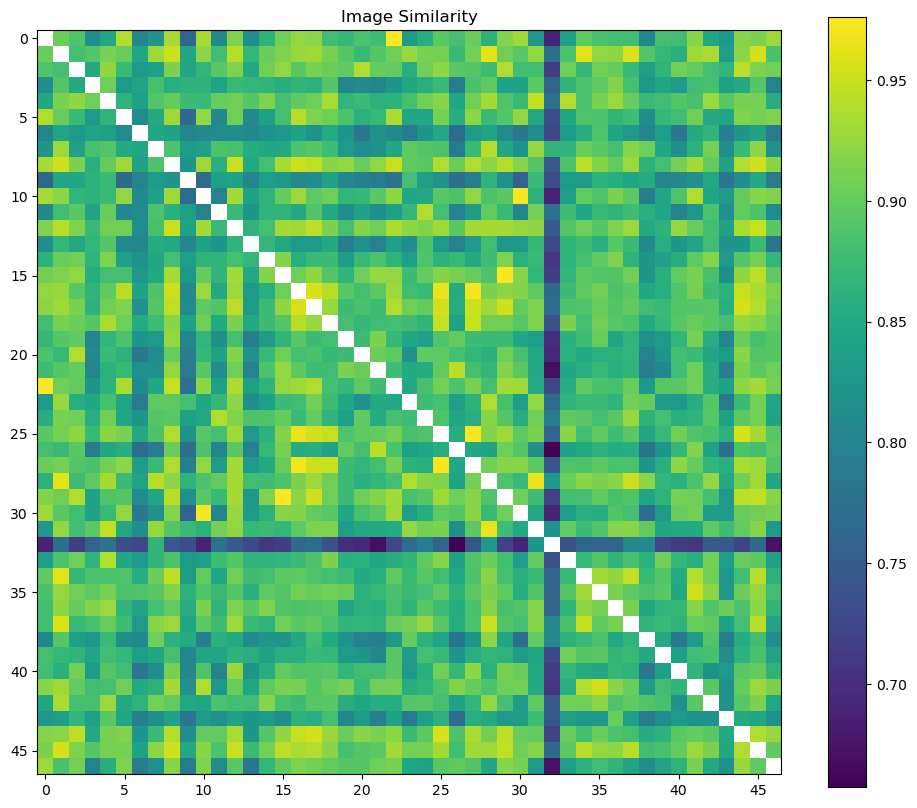

Image to class name similarity mean: 0.21533203125
Image to class name similarity std: 0.020538330078125
Image to class name similarity diagonal mean: 0.2568359375
Image to class name similarity diagonal std: 0.0223388671875
Image to class name similarity non-diagonal mean: 0.2144775390625
Image to class name similarity non-diagonal std: 0.01953125
Image to class name similarity diagonal mean to non-diagonal mean ratio: 1.197265625
Rank 1: (30)(Image)polka-dotted - (10)(Text)dotted, similarity: 0.291259765625
Rank 2: (10)(Image)dotted - (30)(Text)polka-dotted, similarity: 0.288818359375
Rank 3: (0)(Image)banded - (39)(Text)striped, similarity: 0.27685546875
Rank 4: (25)(Image)meshed - (27)(Text)perforated, similarity: 0.27294921875
Rank 5: (27)(Image)perforated - (10)(Text)dotted, similarity: 0.26953125
Rank 6: (16)(Image)grid - (27)(Text)perforated, similarity: 0.263916015625
Rank 7: (40)(Image)studded - (27)(Text)perforated, similarity: 0.26220703125
Rank 8: (22)(Image)lined - (39)(T

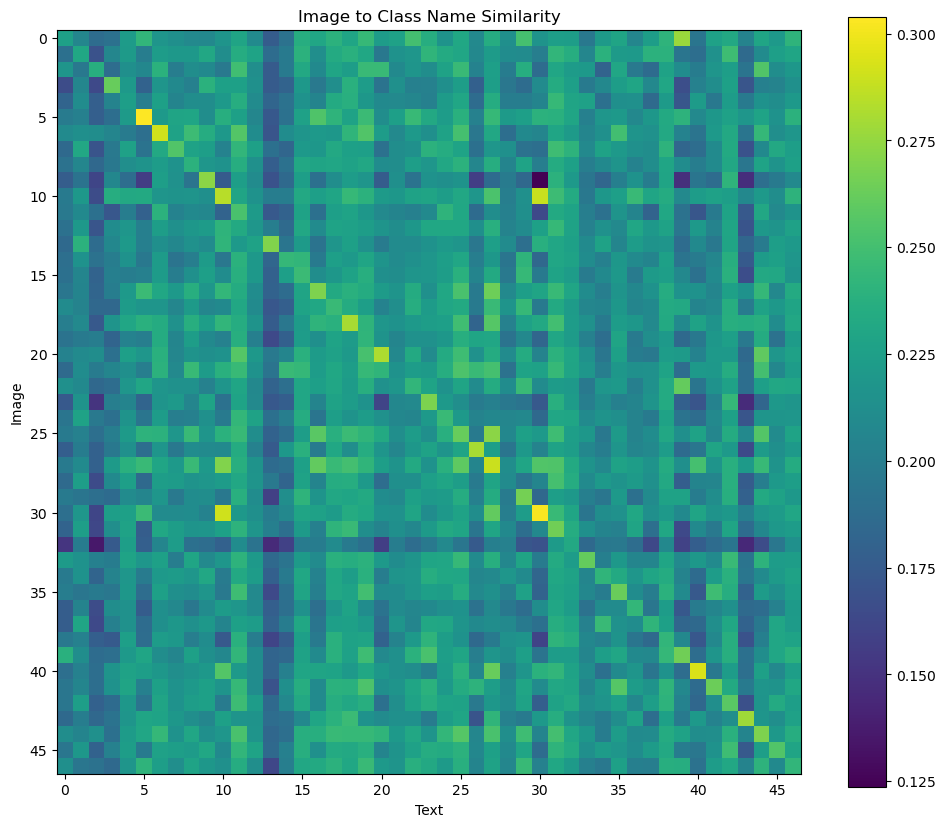

Rank 1: (0)(Image)banded - (39)(Text)striped, error rate: 0.8611111111111112
Rank 2: (22)(Image)lined - (39)(Text)striped, error rate: 0.6111111111111112
Rank 3: (10)(Image)dotted - (30)(Text)polka-dotted, error rate: 0.5833333333333334
Rank 4: (25)(Image)meshed - (27)(Text)perforated, error rate: 0.5833333333333334
Rank 5: (28)(Image)pitted - (31)(Text)porous, error rate: 0.5277777777777778
Rank 6: (16)(Image)grid - (27)(Text)perforated, error rate: 0.3611111111111111
Rank 7: (24)(Image)matted - (11)(Text)fibrous, error rate: 0.3611111111111111
Rank 8: (15)(Image)gauzy - (29)(Text)pleated, error rate: 0.3055555555555556
Rank 9: (14)(Image)frilly - (29)(Text)pleated, error rate: 0.2777777777777778
Rank 10: (37)(Image)stained - (34)(Text)smeared, error rate: 0.2777777777777778
Rank 11: (17)(Image)grooved - (29)(Text)pleated, error rate: 0.2777777777777778
Rank 12: (4)(Image)bumpy - (18)(Text)honeycombed, error rate: 0.2777777777777778
Rank 13: (4)(Image)bumpy - (31)(Text)porous, error r

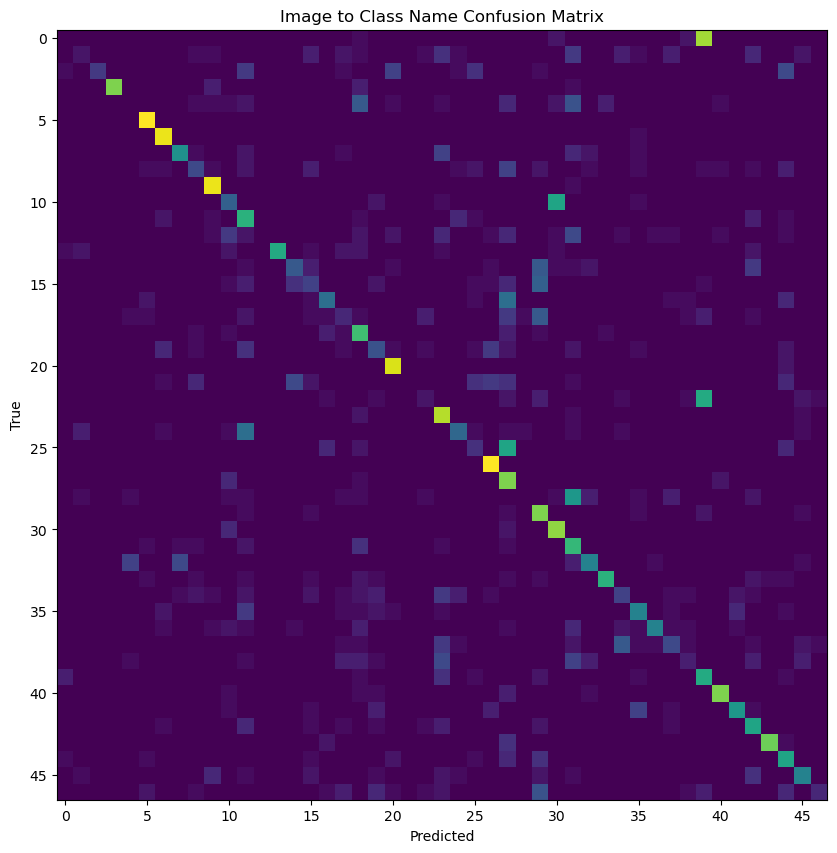

Image to text template (centroid) similarity mean: 0.2362060546875
Image to text template (centroid) similarity std: 0.018280029296875
Image to text template (centroid) similarity diagonal mean: 0.279541015625
Image to text template (centroid) similarity diagonal std: 0.0232391357421875
Image to text template (centroid) similarity non-diagonal mean: 0.2352294921875
Image to text template (centroid) similarity non-diagonal std: 0.0169525146484375
Image to text template (centroid) similarity diagonal mean to non-diagonal mean ratio: 1.1884765625
Rank 1: (10)(Image)dotted - (30)(Text)polka-dotted, similarity: 0.3193359375
Rank 2: (30)(Image)polka-dotted - (10)(Text)dotted, similarity: 0.303955078125
Rank 3: (0)(Image)banded - (39)(Text)striped, similarity: 0.297119140625
Rank 4: (27)(Image)perforated - (10)(Text)dotted, similarity: 0.294677734375
Rank 5: (27)(Image)perforated - (30)(Text)polka-dotted, similarity: 0.29443359375
Rank 6: (25)(Image)meshed - (27)(Text)perforated, similarity: 

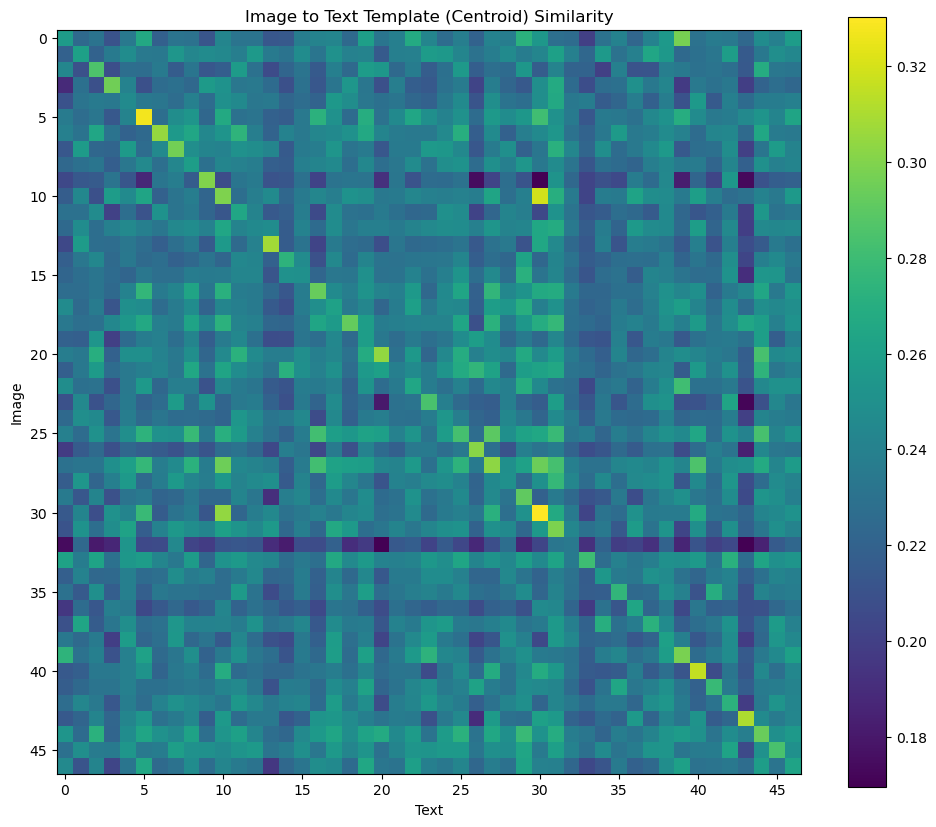

Rank 1: (10)(Image)dotted - (30)(Text)polka-dotted, error rate: 0.9166666666666666
Rank 2: (0)(Image)banded - (39)(Text)striped, error rate: 0.8333333333333334
Rank 3: (32)(Image)potholed - (4)(Text)bumpy, error rate: 0.6666666666666666
Rank 4: (22)(Image)lined - (39)(Text)striped, error rate: 0.6388888888888888
Rank 5: (28)(Image)pitted - (31)(Text)porous, error rate: 0.5833333333333334
Rank 6: (15)(Image)gauzy - (29)(Text)pleated, error rate: 0.5277777777777778
Rank 7: (17)(Image)grooved - (29)(Text)pleated, error rate: 0.4722222222222222
Rank 8: (25)(Image)meshed - (27)(Text)perforated, error rate: 0.3888888888888889
Rank 9: (46)(Image)zigzagged - (5)(Text)chequered, error rate: 0.3611111111111111
Rank 10: (19)(Image)interlaced - (26)(Text)paisley, error rate: 0.3333333333333333
Rank 11: (21)(Image)lacelike - (26)(Text)paisley, error rate: 0.3333333333333333
Rank 12: (4)(Image)bumpy - (31)(Text)porous, error rate: 0.3333333333333333
Rank 13: (35)(Image)spiralled - (41)(Text)swirly, 

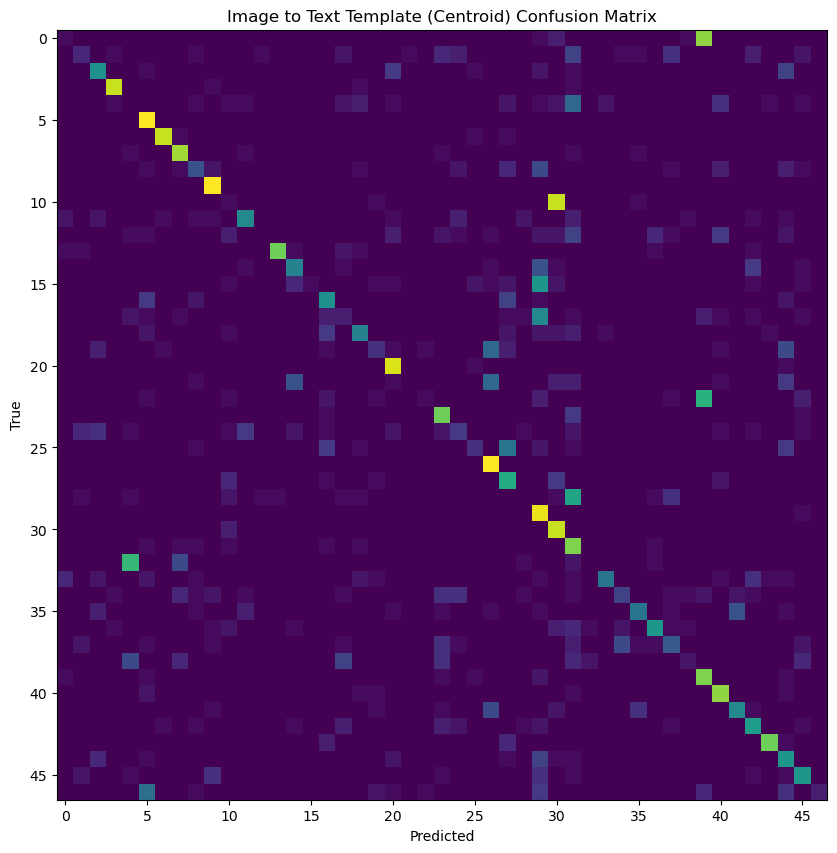

Image to text template (individual avg) similarity mean: 0.21840550005435944
Image to text template (individual avg) similarity std: 0.017073074355721474
Image to text template (individual avg) similarity diagonal mean: 0.25859686732292175
Image to text template (individual avg) similarity diagonal std: 0.021459579467773438
Image to text template (individual avg) similarity non-diagonal mean: 0.21753178536891937
Image to text template (individual avg) similarity non-diagonal std: 0.01587248593568802
Image to text template (individual avg) similarity diagonal mean to non-diagonal mean ratio: 1.1887773275375366
Rank 1: (10)(Image)dotted - (30)(Text)polka-dotted, similarity: 0.296875
Rank 2: (30)(Image)polka-dotted - (10)(Text)dotted, similarity: 0.279052734375
Rank 3: (27)(Image)perforated - (30)(Text)polka-dotted, similarity: 0.273681640625
Rank 4: (0)(Image)banded - (39)(Text)striped, similarity: 0.27294921875
Rank 5: (27)(Image)perforated - (10)(Text)dotted, similarity: 0.2705078125
R

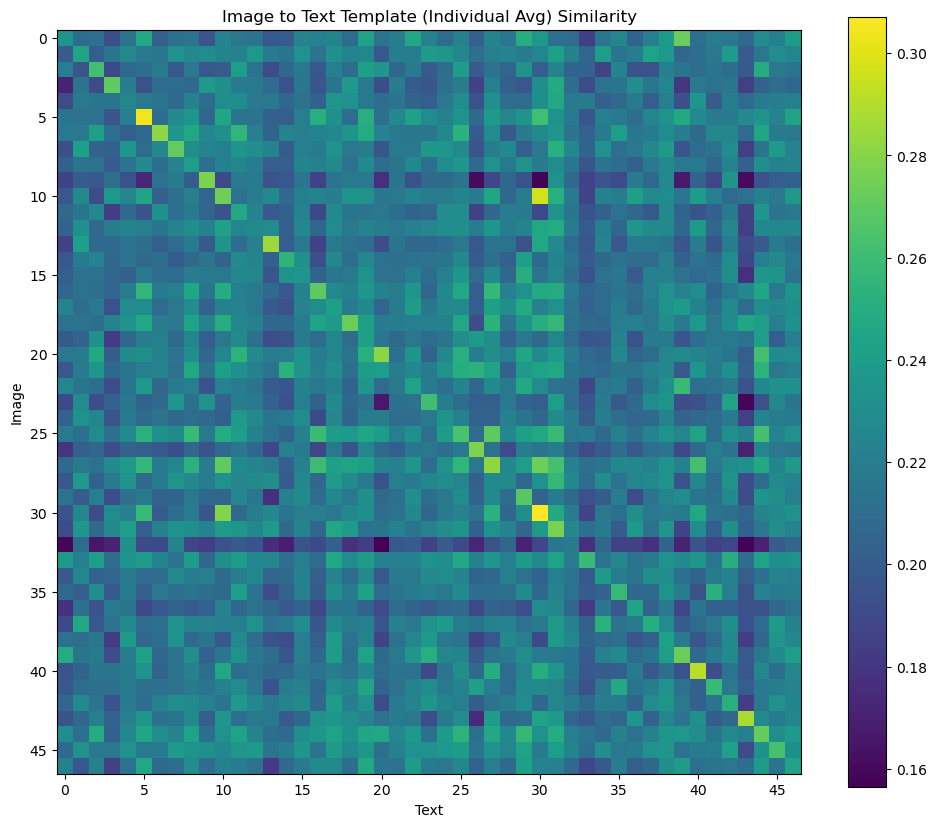

Rank 1: (10)(Image)dotted - (30)(Text)polka-dotted, error rate: 0.9444444444444444
Rank 2: (0)(Image)banded - (39)(Text)striped, error rate: 0.8055555555555556
Rank 3: (32)(Image)potholed - (4)(Text)bumpy, error rate: 0.6666666666666666
Rank 4: (22)(Image)lined - (39)(Text)striped, error rate: 0.6111111111111112
Rank 5: (28)(Image)pitted - (31)(Text)porous, error rate: 0.5555555555555556
Rank 6: (15)(Image)gauzy - (29)(Text)pleated, error rate: 0.5277777777777778
Rank 7: (25)(Image)meshed - (27)(Text)perforated, error rate: 0.4444444444444444
Rank 8: (17)(Image)grooved - (29)(Text)pleated, error rate: 0.4444444444444444
Rank 9: (46)(Image)zigzagged - (5)(Text)chequered, error rate: 0.3888888888888889
Rank 10: (4)(Image)bumpy - (31)(Text)porous, error rate: 0.3055555555555556
Rank 11: (21)(Image)lacelike - (26)(Text)paisley, error rate: 0.2777777777777778
Rank 12: (21)(Image)lacelike - (14)(Text)frilly, error rate: 0.2777777777777778
Rank 13: (35)(Image)spiralled - (41)(Text)swirly, err

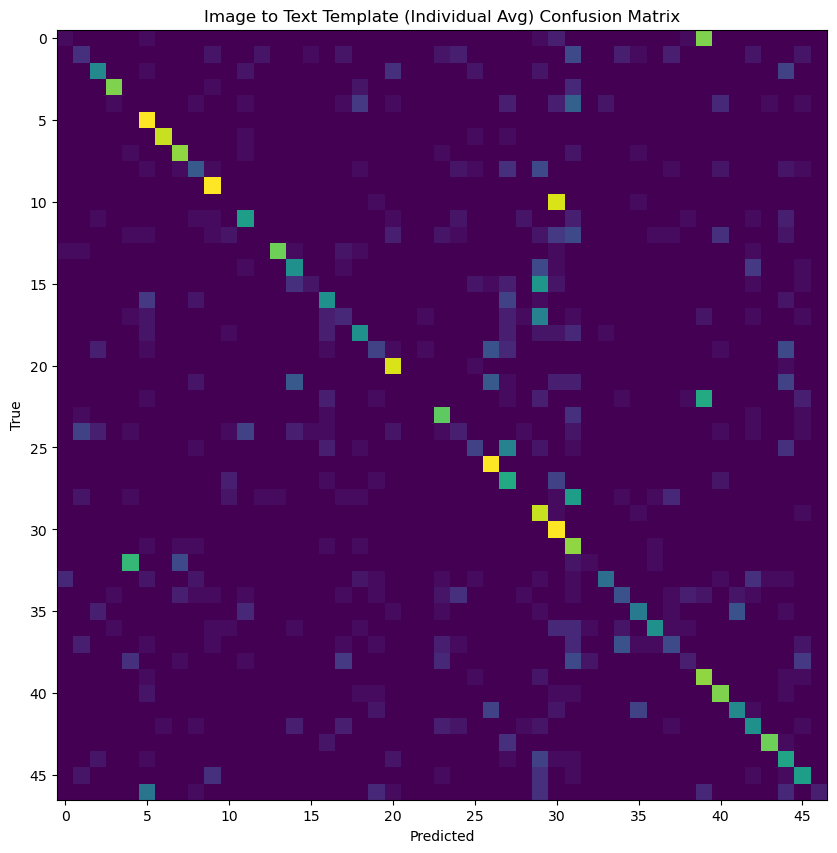

Image to original gpt-3 text (centroid) similarity mean: 0.25146484375
Image to original gpt-3 text (centroid) similarity std: 0.0200958251953125
Image to original gpt-3 text (centroid) similarity diagonal mean: 0.299560546875
Image to original gpt-3 text (centroid) similarity diagonal std: 0.0206451416015625
Image to original gpt-3 text (centroid) similarity non-diagonal mean: 0.25048828125
Image to original gpt-3 text (centroid) similarity non-diagonal std: 0.0187530517578125
Image to original gpt-3 text (centroid) similarity diagonal mean to non-diagonal mean ratio: 1.1962890625
Rank 1: (10)(Image)dotted - (30)(Text)polka-dotted, similarity: 0.333251953125
Rank 2: (30)(Image)polka-dotted - (10)(Text)dotted, similarity: 0.325927734375
Rank 3: (0)(Image)banded - (39)(Text)striped, similarity: 0.320556640625
Rank 4: (27)(Image)perforated - (10)(Text)dotted, similarity: 0.307861328125
Rank 5: (18)(Image)honeycombed - (43)(Text)waffled, similarity: 0.30322265625
Rank 6: (21)(Image)laceli

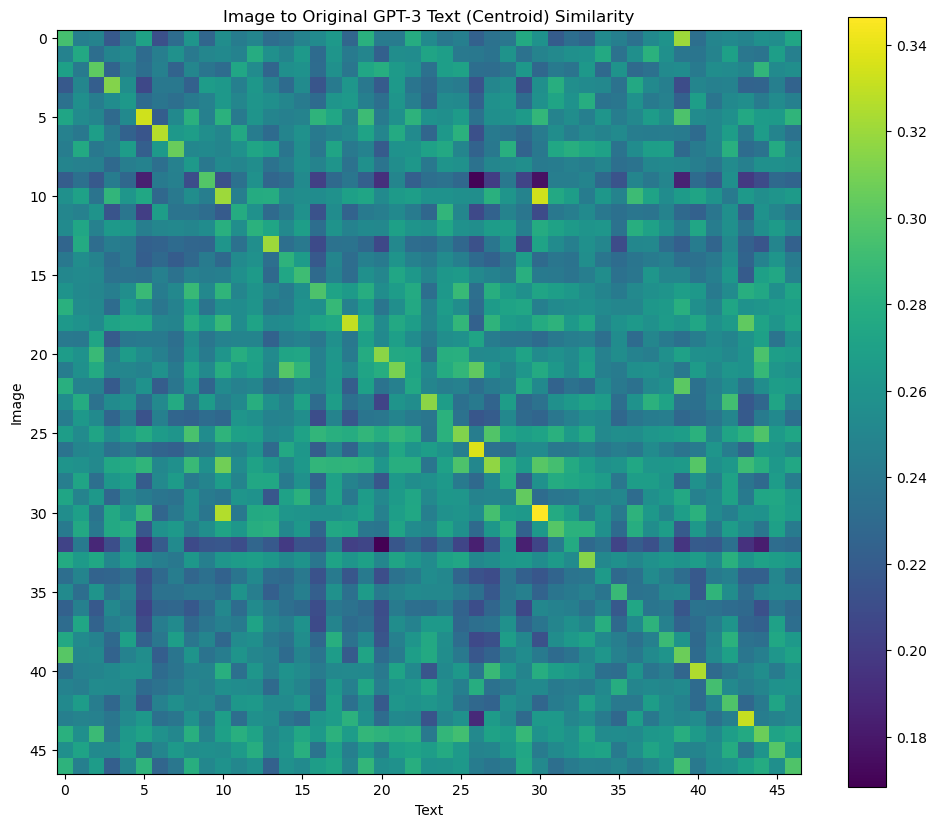

Rank 1: (0)(Image)banded - (39)(Text)striped, error rate: 0.9444444444444444
Rank 2: (10)(Image)dotted - (30)(Text)polka-dotted, error rate: 0.7777777777777778
Rank 3: (22)(Image)lined - (39)(Text)striped, error rate: 0.6944444444444444
Rank 4: (11)(Image)fibrous - (24)(Text)matted, error rate: 0.5555555555555556
Rank 5: (4)(Image)bumpy - (33)(Text)scaly, error rate: 0.4444444444444444
Rank 6: (41)(Image)swirly - (26)(Text)paisley, error rate: 0.3611111111111111
Rank 7: (19)(Image)interlaced - (26)(Text)paisley, error rate: 0.3055555555555556
Rank 8: (17)(Image)grooved - (39)(Text)striped, error rate: 0.2777777777777778
Rank 9: (1)(Image)blotchy - (23)(Text)marbled, error rate: 0.25
Rank 10: (37)(Image)stained - (34)(Text)smeared, error rate: 0.2222222222222222
Rank 11: (12)(Image)flecked - (36)(Text)sprinkled, error rate: 0.2222222222222222
Rank 12: (21)(Image)lacelike - (26)(Text)paisley, error rate: 0.2222222222222222
Rank 13: (35)(Image)spiralled - (41)(Text)swirly, error rate: 0.2

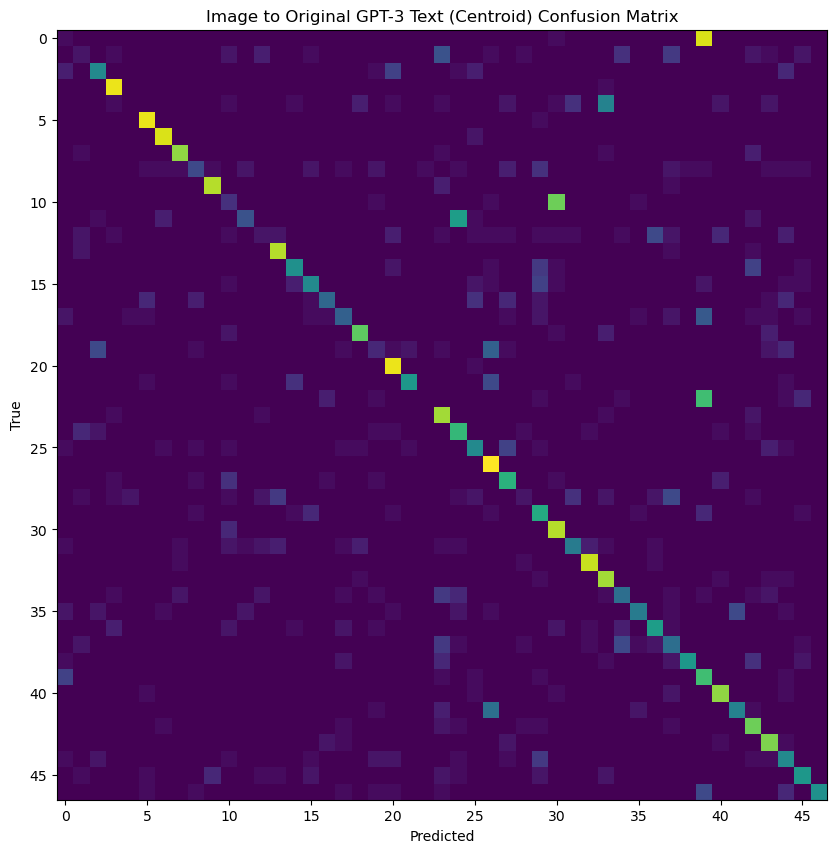

Image to original gpt-3 text (individual avg) similarity mean: 0.2373283952474594
Image to original gpt-3 text (individual avg) similarity std: 0.01906559057533741
Image to original gpt-3 text (individual avg) similarity diagonal mean: 0.28292521834373474
Image to original gpt-3 text (individual avg) similarity diagonal std: 0.020328601822257042
Image to original gpt-3 text (individual avg) similarity non-diagonal mean: 0.23633715510368347
Image to original gpt-3 text (individual avg) similarity non-diagonal std: 0.01778300851583481
Image to original gpt-3 text (individual avg) similarity diagonal mean to non-diagonal mean ratio: 1.1971254348754883
Rank 1: (10)(Image)dotted - (30)(Text)polka-dotted, similarity: 0.319091796875
Rank 2: (30)(Image)polka-dotted - (10)(Text)dotted, similarity: 0.30859375
Rank 3: (0)(Image)banded - (39)(Text)striped, similarity: 0.302490234375
Rank 4: (27)(Image)perforated - (10)(Text)dotted, similarity: 0.29150390625
Rank 5: (21)(Image)lacelike - (26)(Text)

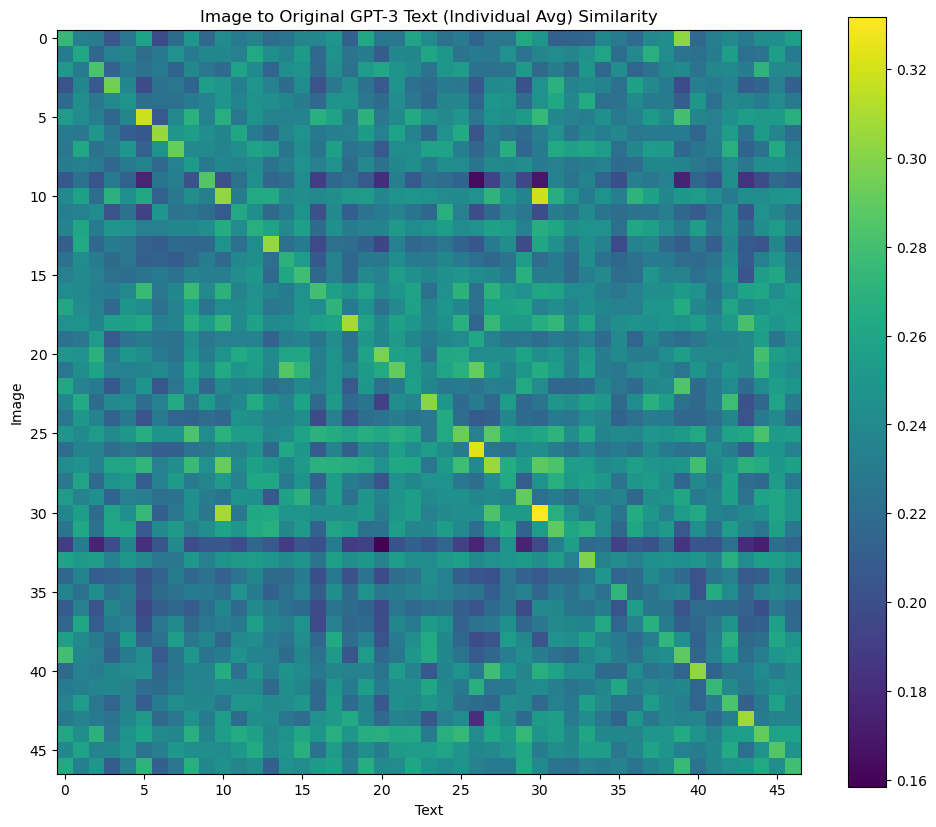

Rank 1: (0)(Image)banded - (39)(Text)striped, error rate: 0.9444444444444444
Rank 2: (10)(Image)dotted - (30)(Text)polka-dotted, error rate: 0.8333333333333334
Rank 3: (22)(Image)lined - (39)(Text)striped, error rate: 0.6944444444444444
Rank 4: (11)(Image)fibrous - (24)(Text)matted, error rate: 0.5
Rank 5: (41)(Image)swirly - (26)(Text)paisley, error rate: 0.4722222222222222
Rank 6: (19)(Image)interlaced - (26)(Text)paisley, error rate: 0.3888888888888889
Rank 7: (4)(Image)bumpy - (33)(Text)scaly, error rate: 0.3888888888888889
Rank 8: (25)(Image)meshed - (27)(Text)perforated, error rate: 0.3611111111111111
Rank 9: (21)(Image)lacelike - (26)(Text)paisley, error rate: 0.3333333333333333
Rank 10: (28)(Image)pitted - (37)(Text)stained, error rate: 0.2777777777777778
Rank 11: (28)(Image)pitted - (31)(Text)porous, error rate: 0.2777777777777778
Rank 12: (1)(Image)blotchy - (23)(Text)marbled, error rate: 0.25
Rank 13: (17)(Image)grooved - (39)(Text)striped, error rate: 0.25
Rank 14: (1)(Imag

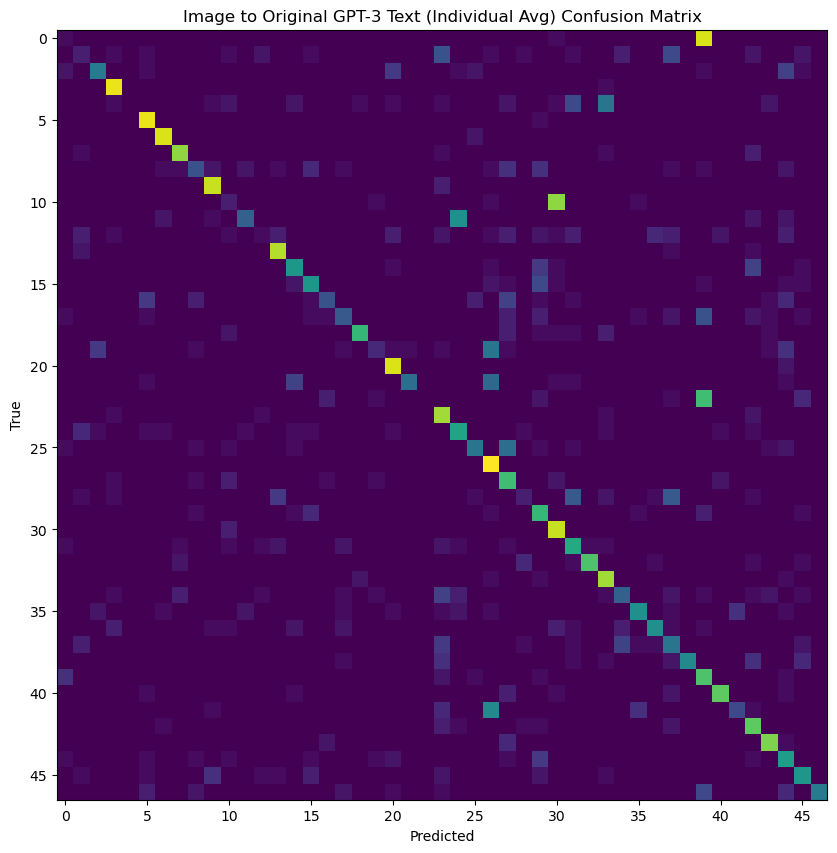

Image to filtered gpt-3 text (centroid) similarity mean: 0.25146484375
Image to filtered gpt-3 text (centroid) similarity std: 0.0200958251953125
Image to filtered gpt-3 text (centroid) similarity diagonal mean: 0.2998046875
Image to filtered gpt-3 text (centroid) similarity diagonal std: 0.020782470703125
Image to filtered gpt-3 text (centroid) similarity non-diagonal mean: 0.25048828125
Image to filtered gpt-3 text (centroid) similarity non-diagonal std: 0.0187530517578125
Image to filtered gpt-3 text (centroid) similarity diagonal mean to non-diagonal mean ratio: 1.197265625
Rank 1: (10)(Image)dotted - (30)(Text)polka-dotted, similarity: 0.3330078125
Rank 2: (30)(Image)polka-dotted - (10)(Text)dotted, similarity: 0.32568359375
Rank 3: (0)(Image)banded - (39)(Text)striped, similarity: 0.32080078125
Rank 4: (27)(Image)perforated - (10)(Text)dotted, similarity: 0.30712890625
Rank 5: (18)(Image)honeycombed - (43)(Text)waffled, similarity: 0.30322265625
Rank 6: (21)(Image)lacelike - (26)

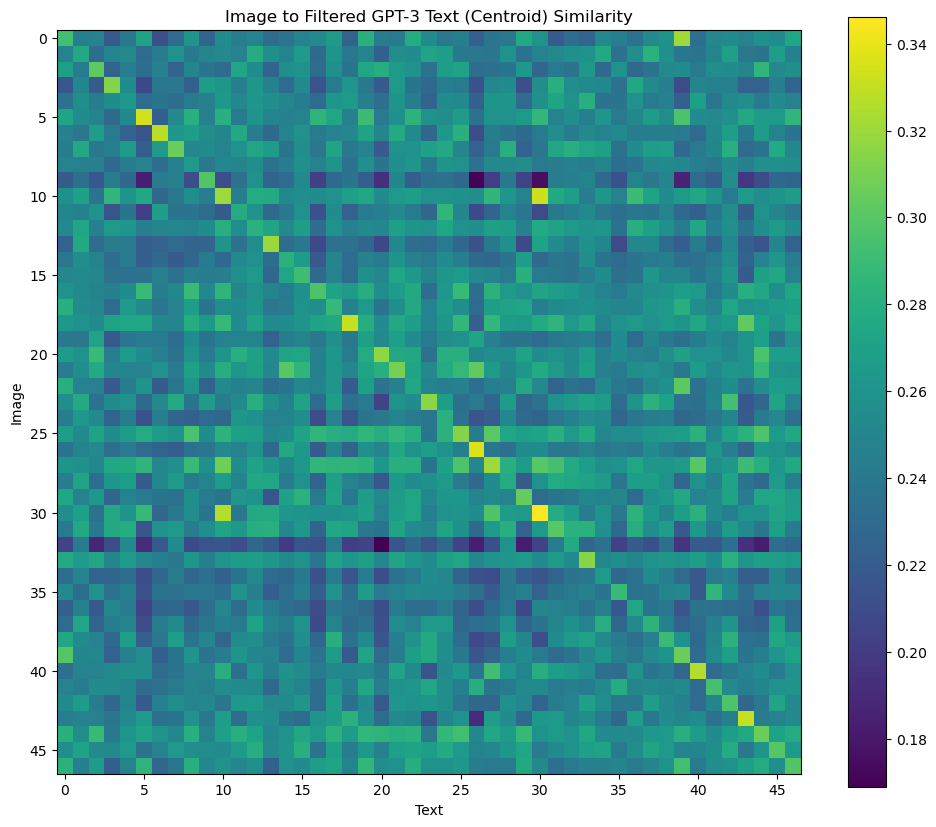

Rank 1: (0)(Image)banded - (39)(Text)striped, error rate: 0.9444444444444444
Rank 2: (10)(Image)dotted - (30)(Text)polka-dotted, error rate: 0.7777777777777778
Rank 3: (22)(Image)lined - (39)(Text)striped, error rate: 0.6944444444444444
Rank 4: (11)(Image)fibrous - (24)(Text)matted, error rate: 0.5555555555555556
Rank 5: (4)(Image)bumpy - (33)(Text)scaly, error rate: 0.4444444444444444
Rank 6: (41)(Image)swirly - (26)(Text)paisley, error rate: 0.3611111111111111
Rank 7: (19)(Image)interlaced - (26)(Text)paisley, error rate: 0.3055555555555556
Rank 8: (17)(Image)grooved - (39)(Text)striped, error rate: 0.3055555555555556
Rank 9: (25)(Image)meshed - (27)(Text)perforated, error rate: 0.2777777777777778
Rank 10: (35)(Image)spiralled - (41)(Text)swirly, error rate: 0.25
Rank 11: (1)(Image)blotchy - (23)(Text)marbled, error rate: 0.25
Rank 12: (28)(Image)pitted - (37)(Text)stained, error rate: 0.2222222222222222
Rank 13: (46)(Image)zigzagged - (39)(Text)striped, error rate: 0.222222222222222

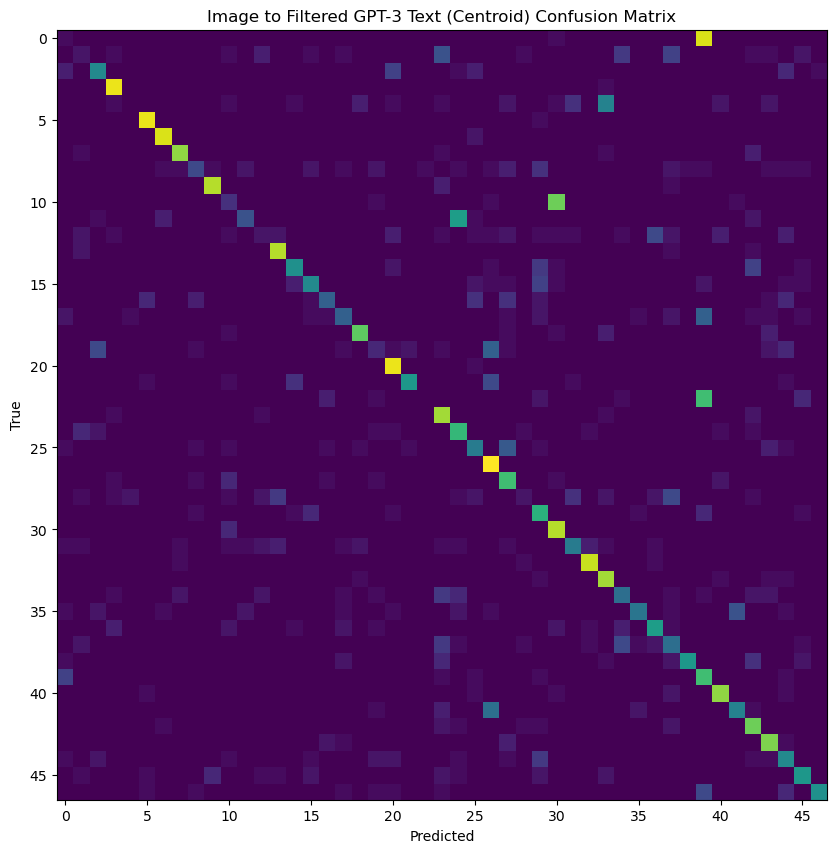

Image to filtered gpt-3 text (individual avg) similarity mean: 0.23743177950382233
Image to filtered gpt-3 text (individual avg) similarity std: 0.019077304750680923
Image to filtered gpt-3 text (individual avg) similarity diagonal mean: 0.28307846188545227
Image to filtered gpt-3 text (individual avg) similarity diagonal std: 0.020525343716144562
Image to filtered gpt-3 text (individual avg) similarity non-diagonal mean: 0.23643946647644043
Image to filtered gpt-3 text (individual avg) similarity non-diagonal std: 0.01778808981180191
Image to filtered gpt-3 text (individual avg) similarity diagonal mean to non-diagonal mean ratio: 1.1972554922103882
Rank 1: (10)(Image)dotted - (30)(Text)polka-dotted, similarity: 0.31884765625
Rank 2: (30)(Image)polka-dotted - (10)(Text)dotted, similarity: 0.3095703125
Rank 3: (0)(Image)banded - (39)(Text)striped, similarity: 0.302734375
Rank 4: (27)(Image)perforated - (10)(Text)dotted, similarity: 0.2919921875
Rank 5: (21)(Image)lacelike - (26)(Text)p

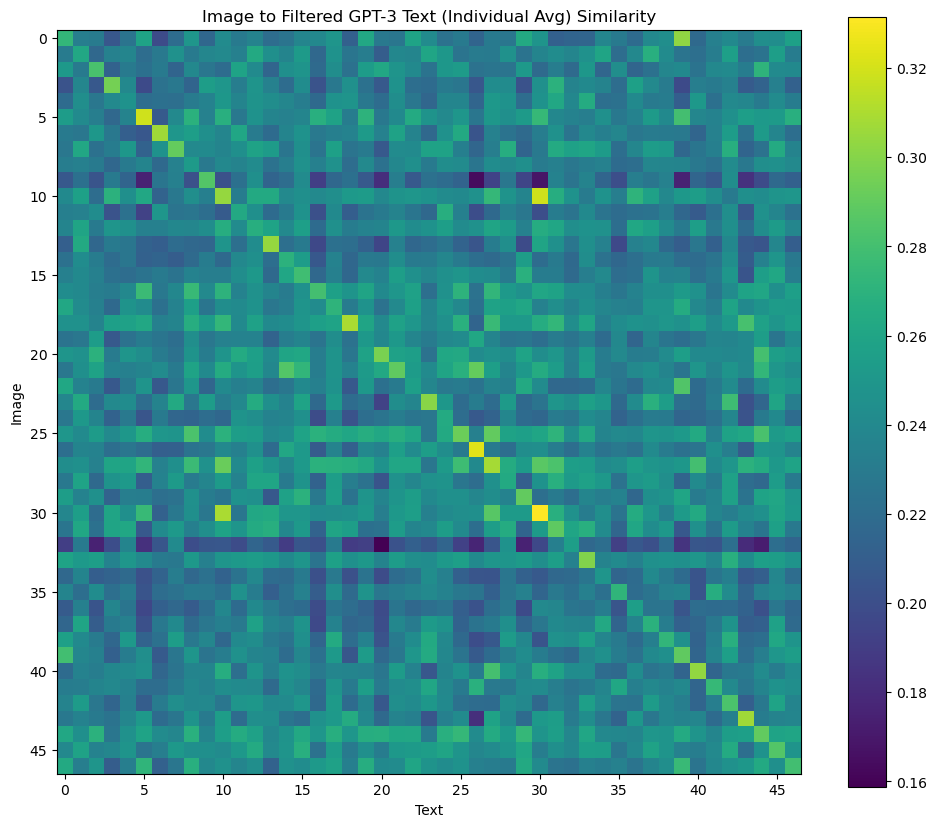

Rank 1: (0)(Image)banded - (39)(Text)striped, error rate: 0.9444444444444444
Rank 2: (10)(Image)dotted - (30)(Text)polka-dotted, error rate: 0.8333333333333334
Rank 3: (22)(Image)lined - (39)(Text)striped, error rate: 0.6944444444444444
Rank 4: (11)(Image)fibrous - (24)(Text)matted, error rate: 0.5
Rank 5: (41)(Image)swirly - (26)(Text)paisley, error rate: 0.4444444444444444
Rank 6: (25)(Image)meshed - (27)(Text)perforated, error rate: 0.3888888888888889
Rank 7: (19)(Image)interlaced - (26)(Text)paisley, error rate: 0.3888888888888889
Rank 8: (4)(Image)bumpy - (33)(Text)scaly, error rate: 0.3888888888888889
Rank 9: (21)(Image)lacelike - (26)(Text)paisley, error rate: 0.3611111111111111
Rank 10: (28)(Image)pitted - (31)(Text)porous, error rate: 0.2777777777777778
Rank 11: (1)(Image)blotchy - (23)(Text)marbled, error rate: 0.25
Rank 12: (17)(Image)grooved - (39)(Text)striped, error rate: 0.25
Rank 13: (16)(Image)grid - (27)(Text)perforated, error rate: 0.25
Rank 14: (4)(Image)bumpy - (31

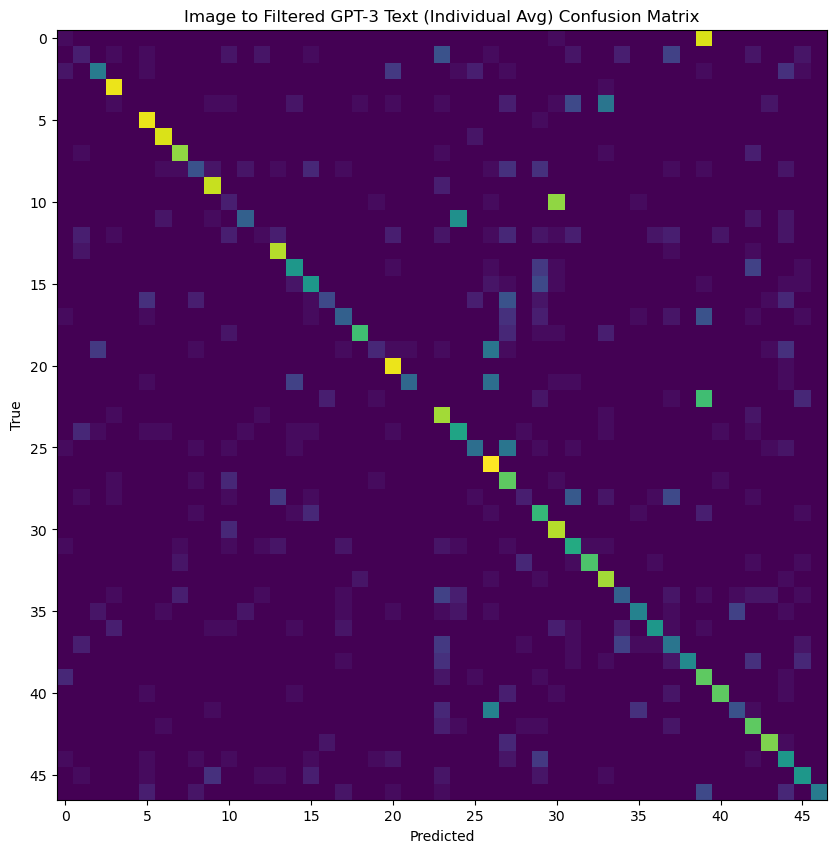

In [37]:
# Auto-similarity of image features
visualize_auto_similarity(img_masked_similarity, 'Image')

# Image to text similarity
visualize_cross_similarity(img_cls_name_similarity, cls_name_cm, 'Image to Class Name')
visualize_cross_similarity(img_template_cls_similarity, template_cls_cm, 'Image to Text Template (Centroid)')
visualize_cross_similarity(img_template_text_similarity, template_text_cm, 'Image to Text Template (Individual Avg)')
visualize_cross_similarity(img_original_gpt3_cls_similarity, original_gpt3_cls_cm, 'Image to Original GPT-3 Text (Centroid)')
visualize_cross_similarity(img_original_gpt3_text_similarity, original_gpt3_text_cm, 'Image to Original GPT-3 Text (Individual Avg)')
visualize_cross_similarity(img_filtered_gpt3_cls_similarity, filtered_gpt3_cls_cm, 'Image to Filtered GPT-3 Text (Centroid)')
visualize_cross_similarity(img_filtered_gpt3_text_similarity, filtered_gpt3_text_cm, 'Image to Filtered GPT-3 Text (Individual Avg)')

In [38]:
# Concatenate all features and labels to be used for plotting
all_label_ids = np.concatenate([cls_name_label_ids, template_label_ids, original_gpt3_label_ids, filtered_gpt3_label_ids])
all_features = np.concatenate([cls_name_features, template_text_features, original_gpt3_text_features, filtered_gpt3_text_features])

cls_name_start_idx = 0
cls_name_end_idx = len(cls_name_features)
template_start_idx = len(cls_name_features)
template_end_idx = len(cls_name_features) + len(template_text_features)
original_gpt3_start_idx = len(cls_name_features) + len(template_text_features)
original_gpt3_end_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features)
filtered_gpt3_start_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features)
filtered_gpt3_end_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features) + len(filtered_gpt3_text_features)

In [39]:
import sklearn.manifold

tsne = sklearn.manifold.TSNE(n_components=2, random_state=42, metric='cosine', perplexity=100)
transformed_features = tsne.fit_transform(all_features)

In [40]:
def calc_centroid(features, label_ids):
    return [features[label_ids == label_id].mean(axis=0) for label_id in range(len(cls_names_sorted))]

In [41]:
cls_name_transformed_features = transformed_features[cls_name_start_idx:cls_name_end_idx]
cls_name_transformed_label_ids = all_label_ids[cls_name_start_idx:cls_name_end_idx]
cls_name_transformed_centroids = calc_centroid(cls_name_transformed_features, cls_name_transformed_label_ids)
template_transformed_features = transformed_features[template_start_idx:template_end_idx]
template_transformed_label_ids = all_label_ids[template_start_idx:template_end_idx]
template_transformed_centroids = calc_centroid(template_transformed_features, template_transformed_label_ids)
original_gpt3_transformed_features = transformed_features[original_gpt3_start_idx:original_gpt3_end_idx]
original_gpt3_transformed_label_ids = all_label_ids[original_gpt3_start_idx:original_gpt3_end_idx]
original_gpt3_transformed_centroids = calc_centroid(original_gpt3_transformed_features, original_gpt3_transformed_label_ids)
filtered_gpt3_transformed_features = transformed_features[filtered_gpt3_start_idx:filtered_gpt3_end_idx]
filtered_gpt3_transformed_label_ids = all_label_ids[filtered_gpt3_start_idx:filtered_gpt3_end_idx]
filtered_gpt3_transformed_centroids = calc_centroid(filtered_gpt3_transformed_features, filtered_gpt3_transformed_label_ids)

In [42]:
import matplotlib.pyplot as plt

def plot_features_2d(features, label_ids, title):
    plt.figure(figsize=(10, 10))
    plt.scatter(features[:, 0], features[:, 1], c=label_ids, cmap='hsv')
    for label_id in range(len(cls_names_sorted)):
        plt.annotate(label_id, (features[label_ids == label_id, 0].mean(), features[label_ids == label_id, 1].mean()), ha='center', va='center', fontsize=12)
    plt.title(title)
    plt.show()

Rank 1: (10)(coor=-20,35)dotted - (30)(coor=-20,35)polka-dotted, similarity: 0.91162109375
Rank 2: (20)(coor=-13,-28)knitted - (44)(coor=-13,-28)woven, similarity: 0.90771484375
Rank 3: (19)(coor=4,-17)interlaced - (35)(coor=4,-17)spiralled, similarity: 0.90185546875
Rank 4: (1)(coor=12,11)blotchy - (12)(coor=12,11)flecked, similarity: 0.900390625
Rank 5: (19)(coor=4,-17)interlaced - (38)(coor=4,-17)stratified, similarity: 0.89697265625
Rank 6: (35)(coor=-20,-38)spiralled - (41)(coor=-20,-38)swirly, similarity: 0.89697265625
Rank 7: (35)(coor=-20,-38)spiralled - (38)(coor=-20,-38)stratified, similarity: 0.89306640625
Rank 8: (31)(coor=2,31)porous - (32)(coor=2,31)potholed, similarity: 0.89208984375
Rank 9: (25)(coor=-7,-16)meshed - (44)(coor=-7,-16)woven, similarity: 0.89013671875
Rank 10: (7)(coor=23,44)cracked - (12)(coor=23,44)flecked, similarity: 0.8876953125


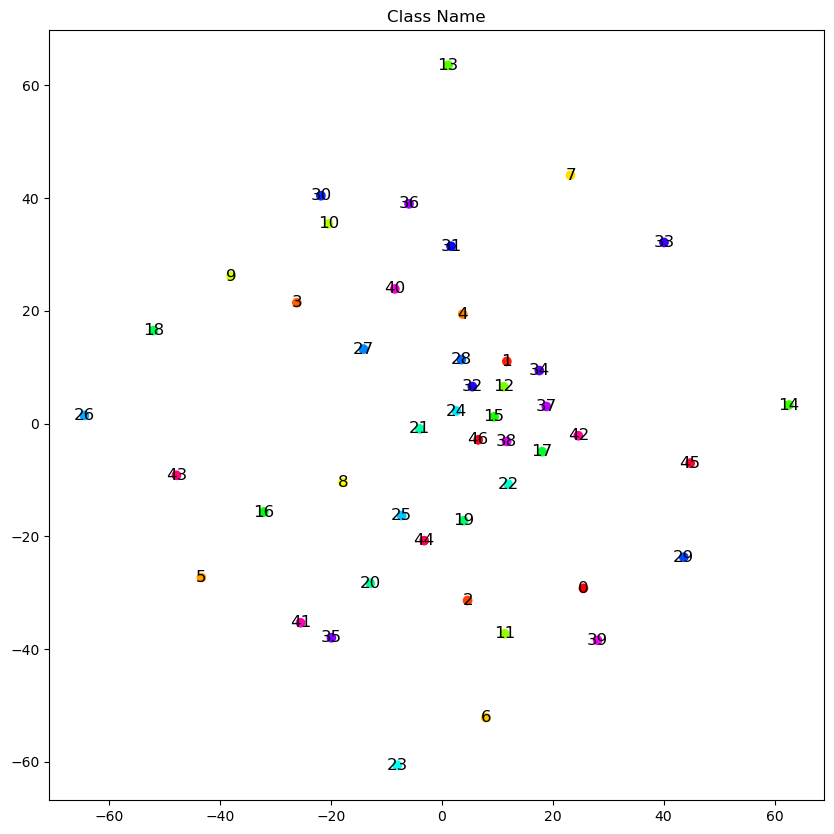

Rank 1: (1)(coor=3,8)blotchy - (12)(coor=3,8)flecked, similarity: 0.943359375
Rank 2: (34)(coor=6,7)smeared - (37)(coor=6,7)stained, similarity: 0.935546875
Rank 3: (10)(coor=-20,27)dotted - (30)(coor=-20,27)polka-dotted, similarity: 0.93408203125
Rank 4: (12)(coor=2,5)flecked - (34)(coor=2,5)smeared, similarity: 0.93359375
Rank 5: (25)(coor=-10,-10)meshed - (44)(coor=-10,-10)woven, similarity: 0.93115234375
Rank 6: (12)(coor=2,5)flecked - (15)(coor=2,5)gauzy, similarity: 0.92919921875
Rank 7: (1)(coor=3,8)blotchy - (34)(coor=3,8)smeared, similarity: 0.92822265625
Rank 8: (35)(coor=-20,-27)spiralled - (41)(coor=-20,-27)swirly, similarity: 0.92724609375
Rank 9: (10)(coor=-20,27)dotted - (27)(coor=-20,27)perforated, similarity: 0.9228515625
Rank 10: (12)(coor=2,5)flecked - (32)(coor=2,5)potholed, similarity: 0.9228515625


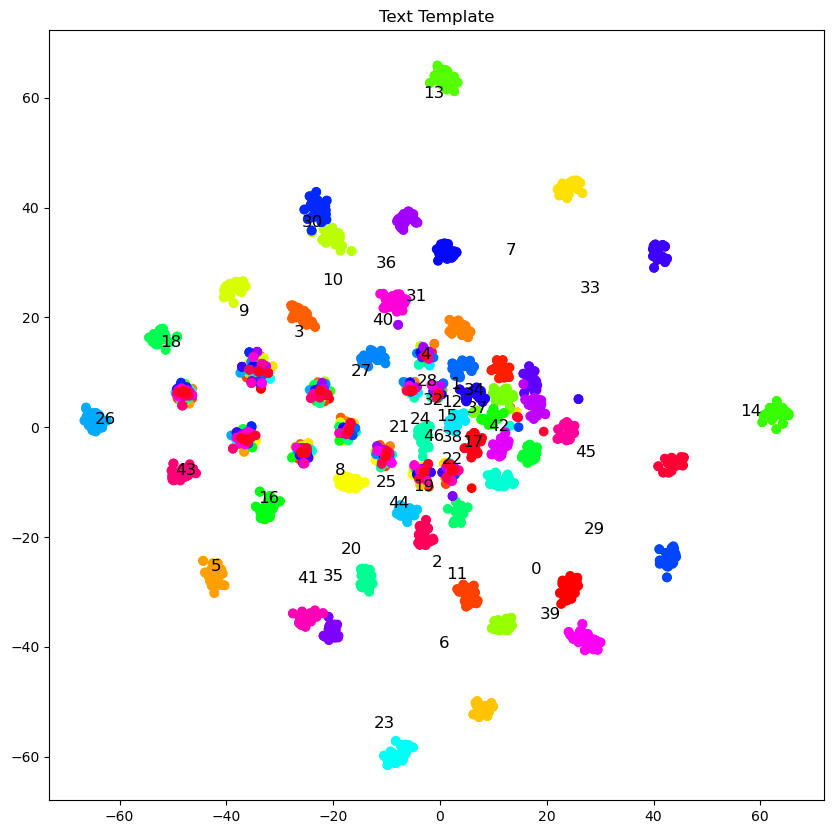

Rank 1: (35)(coor=-22,-42)spiralled - (41)(coor=-22,-42)swirly, similarity: 0.95361328125
Rank 2: (1)(coor=23,23)blotchy - (12)(coor=23,23)flecked, similarity: 0.9443359375
Rank 3: (28)(coor=14,30)pitted - (32)(coor=14,30)potholed, similarity: 0.9443359375
Rank 4: (10)(coor=-15,38)dotted - (30)(coor=-15,38)polka-dotted, similarity: 0.94287109375
Rank 5: (31)(coor=3,36)porous - (32)(coor=3,36)potholed, similarity: 0.939453125
Rank 6: (25)(coor=-10,-20)meshed - (44)(coor=-10,-20)woven, similarity: 0.939453125
Rank 7: (20)(coor=-8,-30)knitted - (44)(coor=-8,-30)woven, similarity: 0.93896484375
Rank 8: (17)(coor=21,-11)grooved - (22)(coor=21,-11)lined, similarity: 0.93896484375
Rank 9: (19)(coor=6,-20)interlaced - (22)(coor=6,-20)lined, similarity: 0.93798828125
Rank 10: (10)(coor=-15,38)dotted - (27)(coor=-15,38)perforated, similarity: 0.931640625


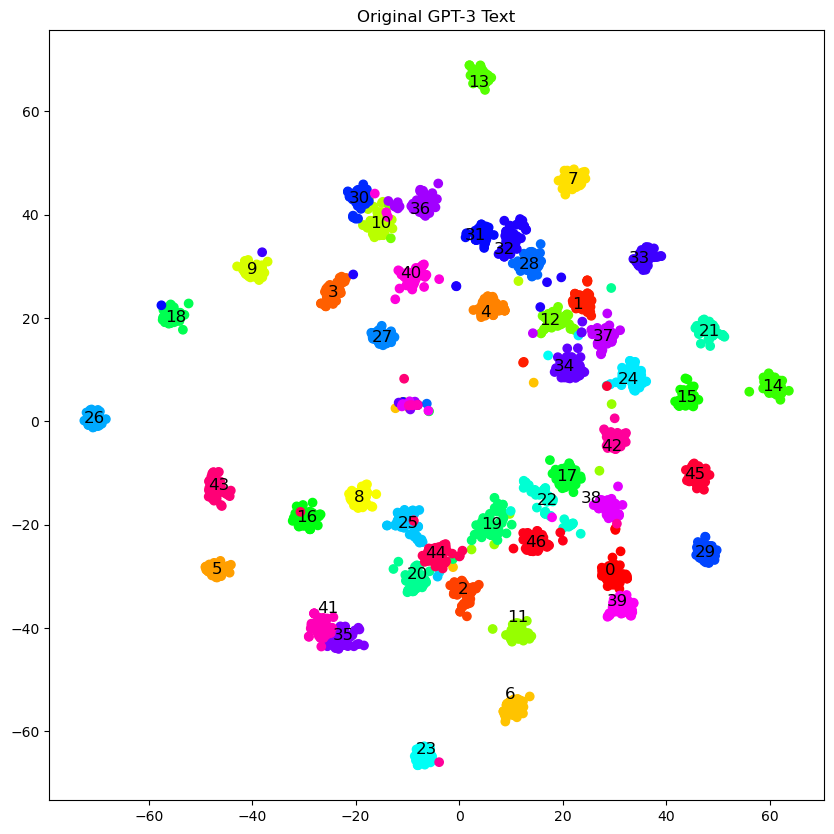

Rank 1: (35)(coor=-22,-41)spiralled - (41)(coor=-22,-41)swirly, similarity: 0.95458984375
Rank 2: (28)(coor=14,30)pitted - (32)(coor=14,30)potholed, similarity: 0.94482421875
Rank 3: (1)(coor=23,23)blotchy - (12)(coor=23,23)flecked, similarity: 0.9443359375
Rank 4: (10)(coor=-15,38)dotted - (30)(coor=-15,38)polka-dotted, similarity: 0.94384765625
Rank 5: (20)(coor=-8,-30)knitted - (44)(coor=-8,-30)woven, similarity: 0.939453125
Rank 6: (31)(coor=3,36)porous - (32)(coor=3,36)potholed, similarity: 0.939453125
Rank 7: (25)(coor=-10,-20)meshed - (44)(coor=-10,-20)woven, similarity: 0.939453125
Rank 8: (17)(coor=21,-11)grooved - (22)(coor=21,-11)lined, similarity: 0.9384765625
Rank 9: (19)(coor=6,-20)interlaced - (22)(coor=6,-20)lined, similarity: 0.9375
Rank 10: (10)(coor=-15,38)dotted - (27)(coor=-15,38)perforated, similarity: 0.93359375


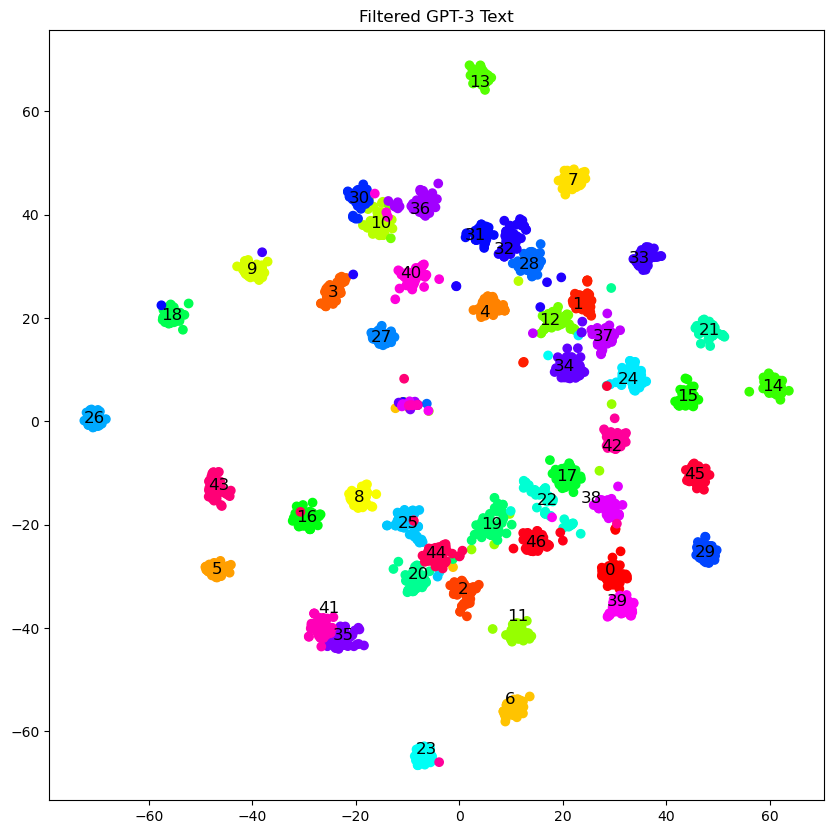

In [43]:
print_top_pairs(np.triu(cls_name_masked_similarity, k=1), 'similarity', coordinates=cls_name_transformed_centroids)
plot_features_2d(cls_name_transformed_features, cls_name_transformed_label_ids, 'Class Name')
print_top_pairs(np.triu(template_masked_similarity, k=1), 'similarity', coordinates=template_transformed_centroids)
plot_features_2d(template_transformed_features, template_transformed_label_ids, 'Text Template')
print_top_pairs(np.triu(original_gpt3_masked_similarity, k=1), 'similarity', coordinates=original_gpt3_transformed_centroids)
plot_features_2d(original_gpt3_transformed_features, original_gpt3_transformed_label_ids, 'Original GPT-3 Text')
print_top_pairs(np.triu(filtered_gpt3_masked_similarity, k=1), 'similarity', coordinates=filtered_gpt3_transformed_centroids)
plot_features_2d(filtered_gpt3_transformed_features, filtered_gpt3_transformed_label_ids, 'Filtered GPT-3 Text')